# AISE4010- Project - Traffic Congestion
#### Group 7:
Aaron Triguero, Khennery Agne, Shiv Patel

---

*With an increasing number of vehicles on the road, managing urban congestions becomes increasingly difficult, leading to increased fuel consumption and carbon emissions.*

*Goal: To predict traffic congestions periods allowing commuters to optimize their travel strategies, allowing for more efficient transportation systems.*


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Normalization
from keras.layers import LSTM, SimpleRNN, Conv1D, GRU
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from time import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# directory to data files
dir = 'drive/MyDrive/Colab Notebooks/4010 T7 Project/data/'   # aaron
# dir = 'drive/MyDrive/Colab Notebooks/4010 T7 Project/data/'    # [insert your directory/drag datasets into files]

Mounted at /content/drive


## View raw files for each variable
- speed, occupancy, travel time
  - for each of the two "complete" datasets we have

                     Occupancy
timestamp                     
2015-09-01 11:30:00      13.56
2015-09-01 11:35:00       8.33
2015-09-01 11:40:00      11.78
2015-09-01 11:55:00      15.28
2015-09-01 12:00:00      10.06


<Axes: title={'center': 'Occupancy'}, xlabel='timestamp', ylabel='average # cars'>

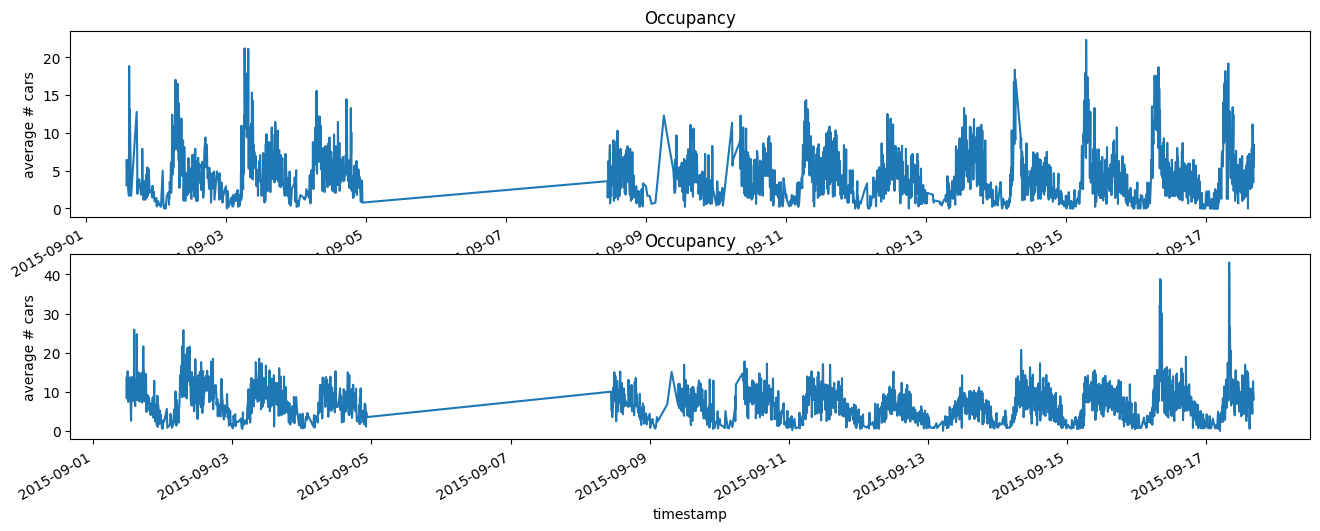

In [ ]:
# Load Occupancy dataset
# ===! Change/remove "dir" variable depending on environment !===
df_o1 = pd.read_csv(dir+'occupancy_6005.csv').rename(columns={'value':'Occupancy'})
df_o2 = pd.read_csv(dir+'occupancy_t4013.csv').rename(columns={'value':'Occupancy'})

# Set index
df_o1['timestamp'] = pd.to_datetime(df_o1['timestamp'])   # to datetime
df_o2['timestamp'] = pd.to_datetime(df_o2['timestamp'])
df_o1 = df_o1.set_index('timestamp')
df_o2 = df_o2.set_index('timestamp')
print(df_o2.head())

# plot
plt.figure(figsize=(16,6))
plt.subplot(2, 1, 1)
df_o1['Occupancy'].plot(ylabel='average # cars',title='Occupancy')
plt.subplot(2, 1, 2)
df_o2['Occupancy'].plot(ylabel='average # cars',title='Occupancy')

                     Travel Time
timestamp                       
2015-07-28 11:56:00          248
2015-07-28 12:06:00          178
2015-07-28 12:25:00          155
2015-07-28 13:56:00          121
2015-07-28 14:06:00          103


<Axes: title={'center': 'Travel Time'}, xlabel='timestamp', ylabel='seconds'>

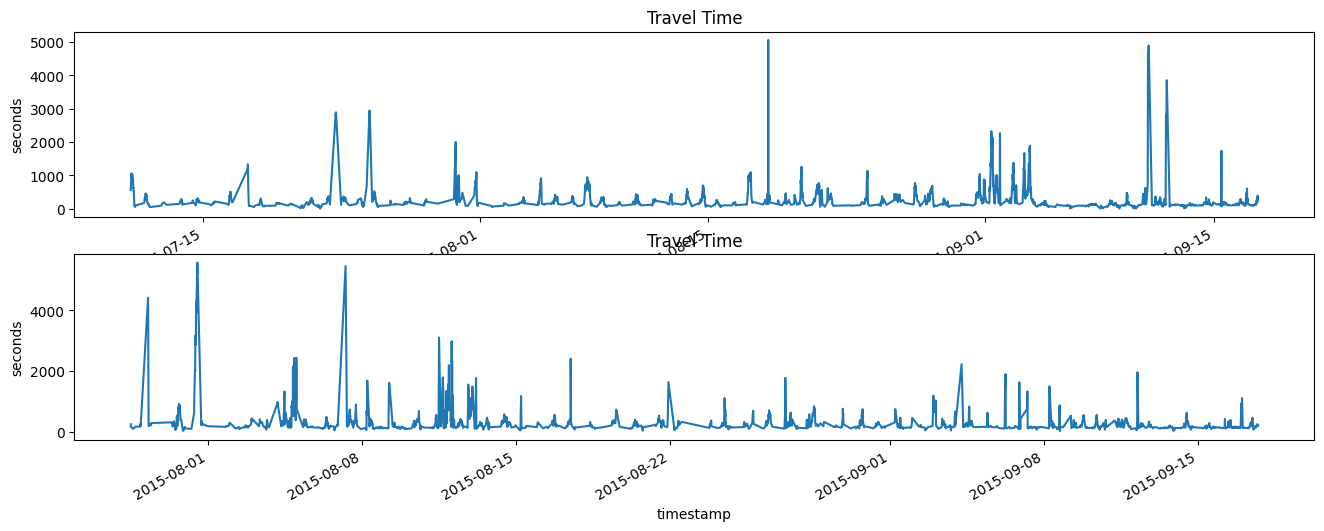

In [ ]:
# Load TravelTime dataset
df_t1 = pd.read_csv(dir+'TravelTime_387.csv').rename(columns={'value':'Travel Time'})
df_t2 = pd.read_csv(dir+'TravelTime_451.csv').rename(columns={'value':'Travel Time'})

# Set index
df_t1['timestamp'] = pd.to_datetime(df_t1['timestamp'])   # to datetime
df_t2['timestamp'] = pd.to_datetime(df_t2['timestamp'])
df_t1 = df_t1.set_index('timestamp')
df_t2 = df_t2.set_index('timestamp')
print(df_t2.head())

# plot
plt.figure(figsize=(16,6))
plt.subplot(2, 1, 1)
df_t1['Travel Time'].plot(ylabel='seconds',title='Travel Time')
plt.subplot(2, 1, 2)
df_t2['Travel Time'].plot(ylabel='seconds', title='Travel Time')

                     Speed
timestamp                 
2015-09-01 11:25:00     58
2015-09-01 11:30:00     63
2015-09-01 11:35:00     63
2015-09-01 11:40:00     64
2015-09-01 11:55:00     58


<Axes: xlabel='timestamp', ylabel='km/h'>

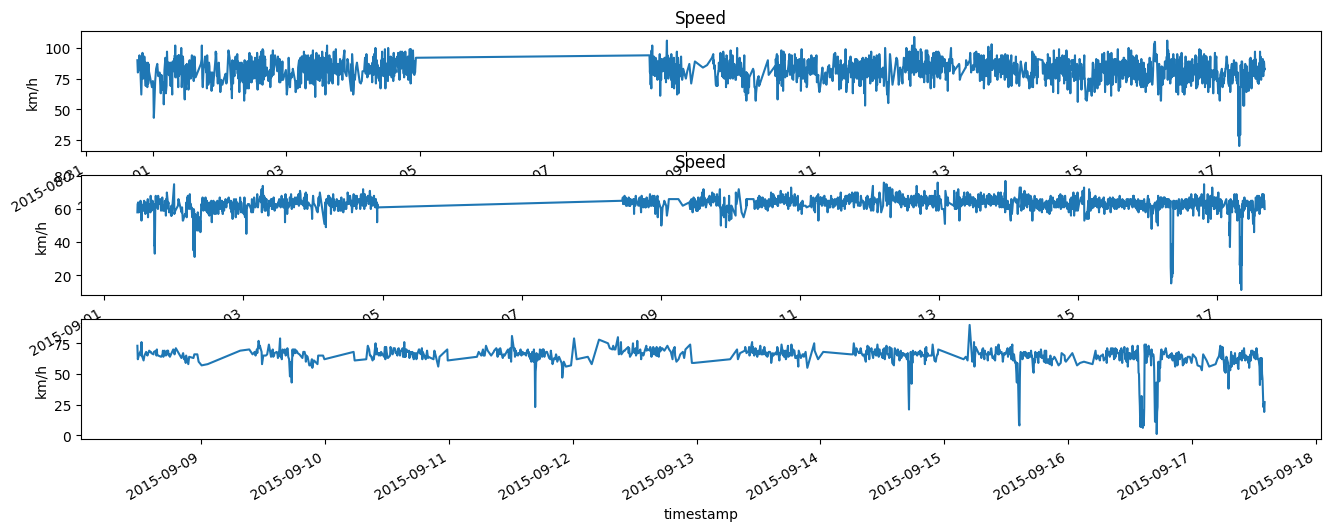

In [ ]:
# Load speed dataset
df_s1 = pd.read_csv(dir+'speed_6005.csv').rename(columns={'value':'Speed'})
df_s2 = pd.read_csv(dir+'speed_t4013.csv').rename(columns={'value':'Speed'})
df_s3 = pd.read_csv(dir+'speed_7578.csv').rename(columns={'value':'Speed'})

# Set index
df_s1['timestamp'] = pd.to_datetime(df_s1['timestamp'])   # to datetime
df_s2['timestamp'] = pd.to_datetime(df_s2['timestamp'])
df_s3['timestamp'] = pd.to_datetime(df_s3['timestamp'])
df_s1 = df_s1.set_index('timestamp')
df_s2 = df_s2.set_index('timestamp')
df_s3 = df_s3.set_index('timestamp')
print(df_s2.head())

# plot
plt.figure(figsize=(16,6))
plt.subplot(3, 1, 1)
df_s1['Speed'].plot(ylabel='km/h',title='Speed')
plt.subplot(3, 1, 2)
df_s2['Speed'].plot(ylabel='km/h',title='Speed')
plt.subplot(3, 1, 3)
df_s3['Speed'].plot(ylabel='km/h')

## 1. Preprocess Data

- Preprocess by joining data, resampling, and normalizing
- Get time series components of each variable
- Split into training, testing sets

#### Joining, Resampling

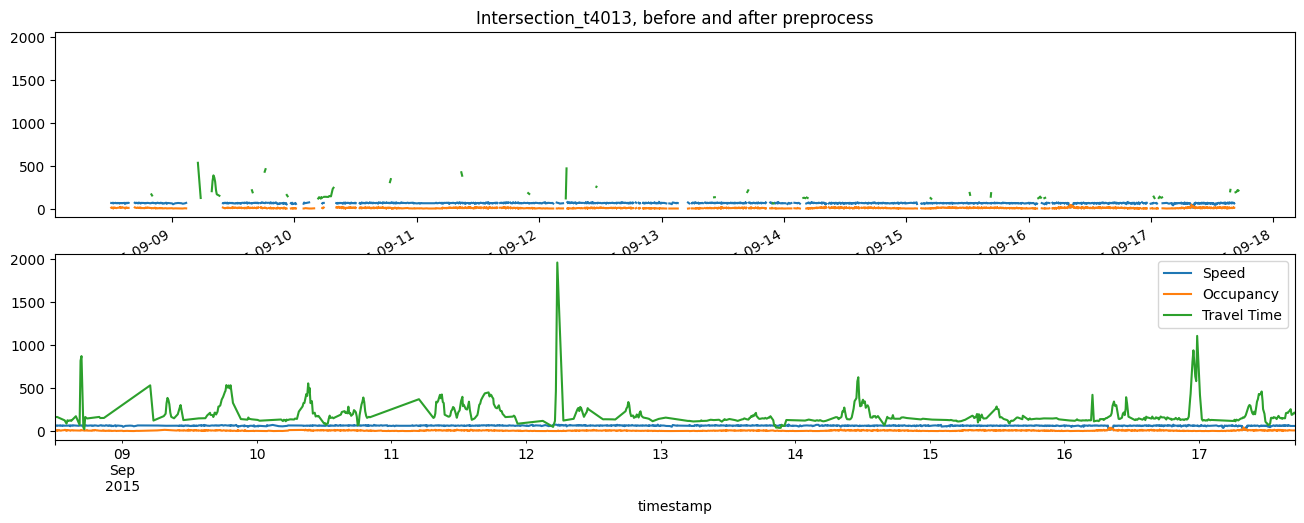

In [ ]:
# Dataset for intersection 6005
# data_6005 = df_o1.join(df_t1, how='outer').join(df_s1, how='outer')
# data_6005 = data_6005['2015-09-09':]  # take only data after certain date             # if we wanted to do 2 intersections

# Dataset for intersection t4013
data_t4013 = df_o2.join(df_t2, how='outer').join(df_s2, how='outer')
data = data_t4013['2015-09-08 12':]  # take only data after certain date



# Plot data before resampling
plt.figure(figsize=(16,6))
plt.subplot(2,1,1)
data['Speed'].plot(title='Intersection_t4013, before and after preprocess')#, ylabel='(different for each variable)')
data['Occupancy'].plot()
data['Travel Time'].plot()


# Data after resampling (using mean) to 5 min intervals
# and handling missing data using _______(interpolation)________
data = data.resample('5min').mean()
data = data.interpolate()

data['Travel Time'] = data['Travel Time'].bfill()   # special case where Travel Time has few initial data points missing

# Normalize each variable using StandardScaler
# scaler_s, scaler_o, scaler_t = StandardScaler(), StandardScaler(), StandardScaler()
# data['Speed'] = scaler_s.fit_transform(data[['Speed']])
# data['Occupancy'] = scaler_o.fit_transform(data[['Occupancy']])
# data['Travel Time'] = scaler_t.fit_transform(data[['Travel Time']])


# Plot data after resampling and filling missing values
plt.subplot(2,1,2)
data['Speed'].plot()
data['Occupancy'].plot()
data['Travel Time'].plot()
plt.legend()
plt.show()


In [ ]:
data.shape    # (2654 timesteps, 3 variables)

(2654, 3)

#### Components of the time series

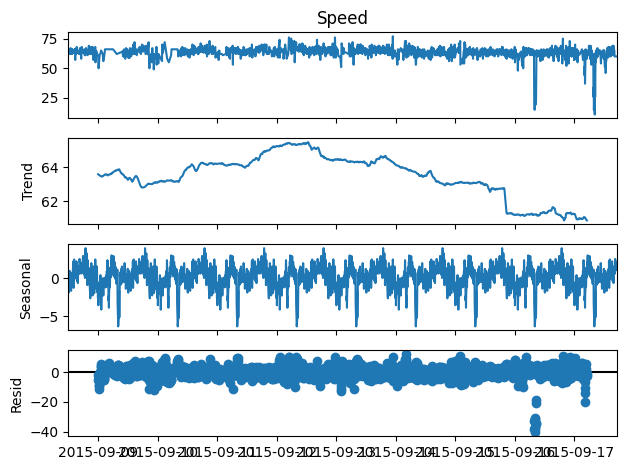

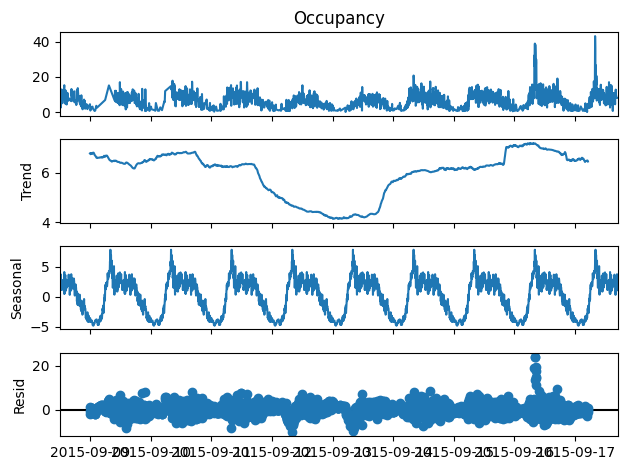

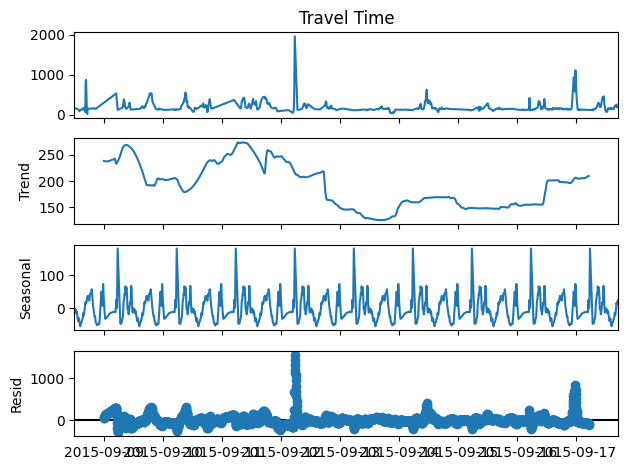

In [ ]:
# check seasonality, trends, etc for each variable

result_speed = seasonal_decompose(data['Speed'], model='additive', period=288)  # 12 5-min intervals per hour, expect daily patterns (12 * 24 = 288)
result_speed.plot()
plt.show()

result_occupancy = seasonal_decompose(data['Occupancy'], model='additive', period=288)
result_occupancy.plot()
plt.show()

result_ttime = seasonal_decompose(data['Travel Time'], model='additive', period=288)
result_ttime.plot()
plt.show()


#### Splitting train, validation, and test sets

- includes where we change the timesteps per sample for entire dataset

In [ ]:
# Sliding window to split data

def sliding_window(data, n):
    # data: original data
    # n: window size
    X, y = [], []
    for i in range(len(data) - n):
        X.append(data[i:(i + n)])
        y.append(data[i + n])
    return np.array(X), np.array(y)


# For n timesteps
n_steps = 12      # each 60 minutes (5 minutes per timestep)

# Each variable
Xo, yo = sliding_window(data['Occupancy'], n_steps)
Xs, ys = sliding_window(data['Speed'], n_steps)
Xt, yt = sliding_window(data['Travel Time'], n_steps)

# Split data into training - validation - testing sets
split_train = int(len(Xo)*0.7)    # 70% train - 15% validation - 15% test
split_val = int(len(Xo)*0.85)

# Train and Validation data (70% + 15%)
Xs_train, Xs_val = Xs[:split_train], Xs[split_train:split_val]
ys_train, ys_val = ys[:split_train], ys[split_train:split_val]

Xo_train, Xo_val = Xo[:split_train], Xo[split_train:split_val]
yo_train, yo_val = yo[:split_train], yo[split_train:split_val]

Xt_train, Xt_val = Xt[:split_train], Xt[split_train:split_val]
yt_train, yt_val = yt[:split_train], yt[split_train:split_val]

# Test data (15%)
Xo_test, yo_test = Xo[split_val:], yo[split_val:]
Xs_test, ys_test = Xs[split_val:], ys[split_val:]
Xt_test, yt_test = Xt[split_val:], yt[split_val:]


<ipython-input-9-a6e53ae59b24>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i + n])


#### Normalizing, Reshaping

In [ ]:
# Normalize each X and y set using StandardScaler
scaler_sx, scaler_ox, scaler_tx = StandardScaler(), StandardScaler(), StandardScaler()
scaler_sy, scaler_oy, scaler_ty = StandardScaler(), StandardScaler(), StandardScaler()

# Normalizing training sets
Xs_train = scaler_sx.fit_transform(Xs_train)  # fit_transform
ys_train = scaler_sy.fit_transform(ys_train.reshape(-1, 1))  # fit_transform

Xo_train = scaler_ox.fit_transform(Xo_train)  # fit_transform
yo_train = scaler_oy.fit_transform(yo_train.reshape(-1, 1))  # fit_transform

Xt_train = scaler_tx.fit_transform(Xt_train)  # fit_transform
yt_train = scaler_ty.fit_transform(yt_train.reshape(-1, 1))  # fit_transform

# Normalizing validation sets
Xs_val = scaler_sx.transform(Xs_val)  # transform
ys_val = scaler_sy.transform(ys_val.reshape(-1, 1))  # transform

Xo_val = scaler_ox.transform(Xo_val)  # transform
yo_val = scaler_oy.transform(yo_val.reshape(-1, 1))  # transform

Xt_val = scaler_tx.transform(Xt_val)  # transform
yt_val = scaler_ty.transform(yt_val.reshape(-1, 1))  # transform

# Normalizing X_test sets
# y_test sets not needed to rescale, as used in original scale
Xs_test = scaler_sx.transform(Xs_test)  # transform
Xo_test = scaler_ox.transform(Xo_test)  # transform
Xt_test = scaler_tx.transform(Xt_test)  # transform



#--
# Reshape (samples, time_steps, feature)
#--
Xo_train = Xo_train.reshape(Xo_train.shape[0], Xo_train.shape[1], 1)
Xo_val = Xo_val.reshape(Xo_val.shape[0], Xo_val.shape[1], 1)
Xo_test = Xo_test.reshape(Xo_test.shape[0], Xo_test.shape[1], 1)

Xs_train = Xs_train.reshape(Xs_train.shape[0], Xs_train.shape[1], 1)
Xs_val = Xs_val.reshape(Xs_val.shape[0], Xs_val.shape[1], 1)
Xs_test = Xs_test.reshape(Xs_test.shape[0], Xs_test.shape[1], 1)

Xt_train = Xt_train.reshape(Xt_train.shape[0], Xt_train.shape[1], 1)
Xt_val = Xt_val.reshape(Xt_val.shape[0], Xt_val.shape[1], 1)
Xt_test = Xt_test.reshape(Xt_test.shape[0], Xt_test.shape[1], 1)

## 2. Model: Training & Testing

- Here we create the models (CNN, RNN, LSTM, GRU) for each variable
- Then train each variable on each model.
- Afterwards, we test each model and get performance.

### CNN Model
Make the model:

In [123]:
# CNN model
model_CNN = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(Xo_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(25, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# Optimizer and loss fn
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
optimizer = Adam(learning_rate=0.0005)
model_CNN.compile(optimizer=optimizer, loss='mean_squared_error')

# Copy models for each variable
model_CNN_s, model_CNN_o, model_CNN_t = model_CNN, model_CNN, model_CNN

# Choose parameters for training
EPOCHS = 50
BATCH_SIZE = 32



#### Training using CNN models

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8723 - val_loss: 2.1502
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7866 - val_loss: 1.9344
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7755 - val_loss: 1.8854
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6742 - val_loss: 1.6676
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6518 - val_loss: 1.6063
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6129 - val_loss: 1.5734
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6597 - val_loss: 1.5688
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6990 - val_loss: 1.6292
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5630 - val_loss: 1.5724
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6748 - val_loss: 1.5776
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5767 - val_loss: 1.5362
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6046 - val_

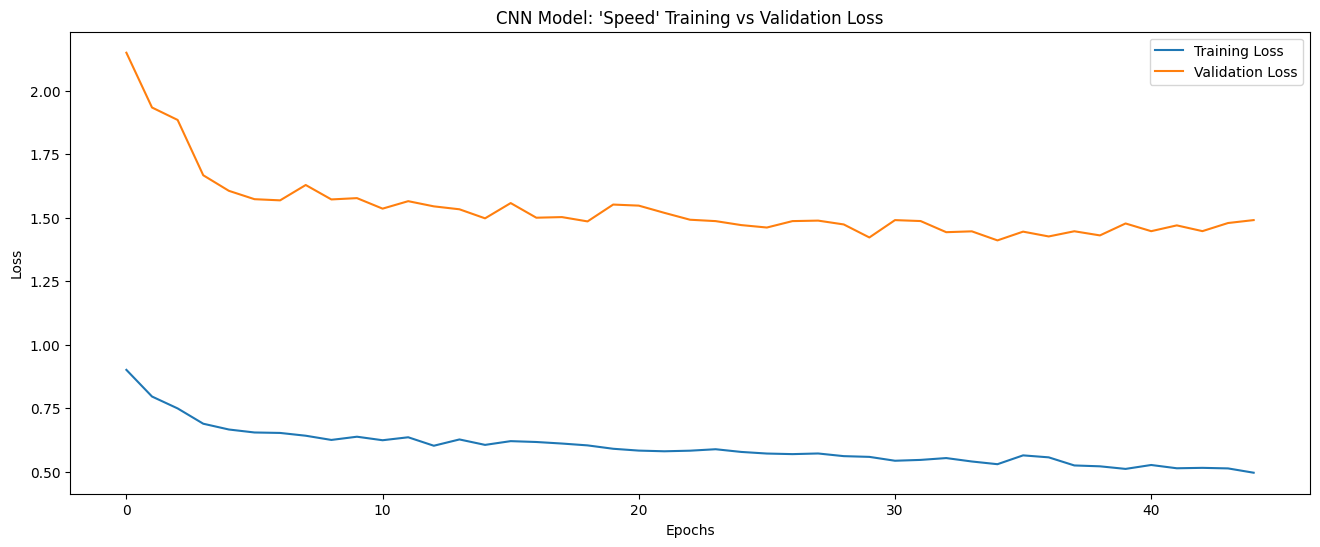

CNN Training Time for 'Speed': 27.086 seconds


In [124]:
# Speed data
start_time = time()
cnn_history_speed = model_CNN_s.fit(Xs_train, ys_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                    validation_data=(Xs_val, ys_val), callbacks=[early_stopping])
cnn_time_speed = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(cnn_history_speed.history['loss'], label='Training Loss')
plt.plot(cnn_history_speed.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model: \'Speed\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"CNN Training Time for \'Speed\': {cnn_time_speed:.3f} seconds")


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4459 - val_loss: 0.5149
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3798 - val_loss: 0.5203
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3878 - val_loss: 0.5169
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3768 - val_loss: 0.5179
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4002 - val_loss: 0.5099
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4095 - val_loss: 0.4958
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3711 - val_loss: 0.5040
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3939 - val_loss: 0.5100
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3758 - val_loss: 0.5023
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3652 - val_loss: 0.5093
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3472 - val_loss: 0.4988
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3523 - val_l

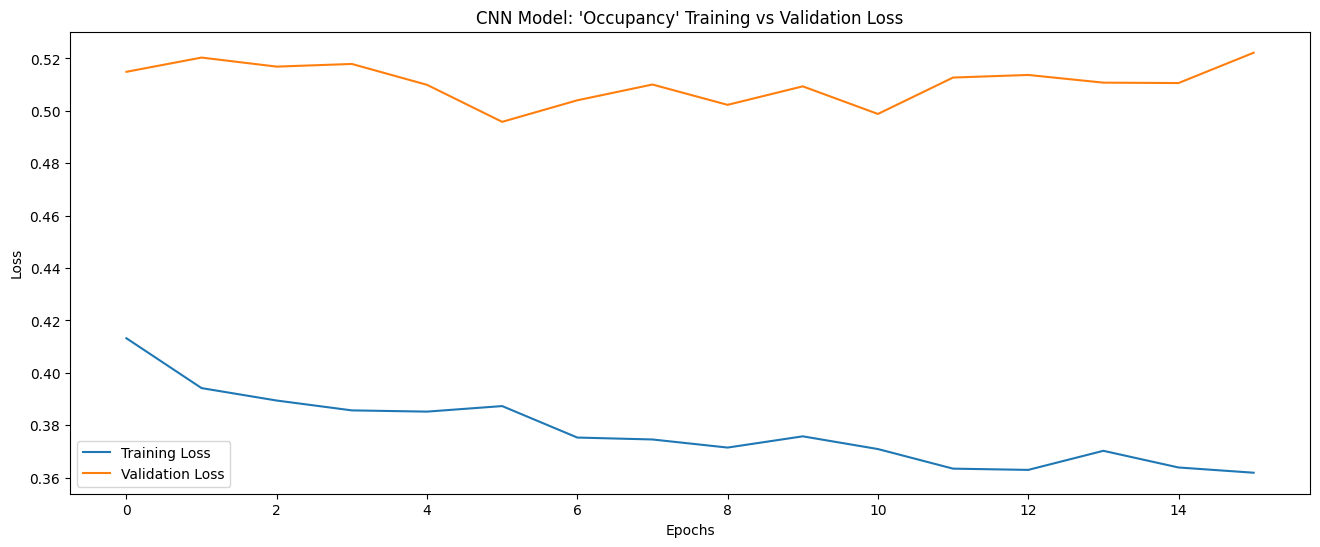

CNN Training Time for 'Occupancy': 8.803 seconds


In [125]:
# Occupancy data
start_time = time()
cnn_history_occupancy = model_CNN_o.fit(Xo_train, yo_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                        validation_data=(Xo_val, yo_val), callbacks=[early_stopping])
cnn_time_occupancy = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(cnn_history_occupancy.history['loss'], label='Training Loss')
plt.plot(cnn_history_occupancy.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model: \'Occupancy\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"CNN Training Time for \'Occupancy\': {cnn_time_occupancy:.3f} seconds")

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2145 - val_loss: 0.0173
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1355 - val_loss: 0.0161
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1464 - val_loss: 0.0153
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0932 - val_loss: 0.0129
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1667 - val_loss: 0.0130
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1148 - val_loss: 0.0159
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2588 - val_loss: 0.0167
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1229 - val_loss: 0.0153
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0730 - val_loss: 0.0180
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0809 - val_loss: 0.0145
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0571 - val_loss: 0.0190
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1094 - val_lo

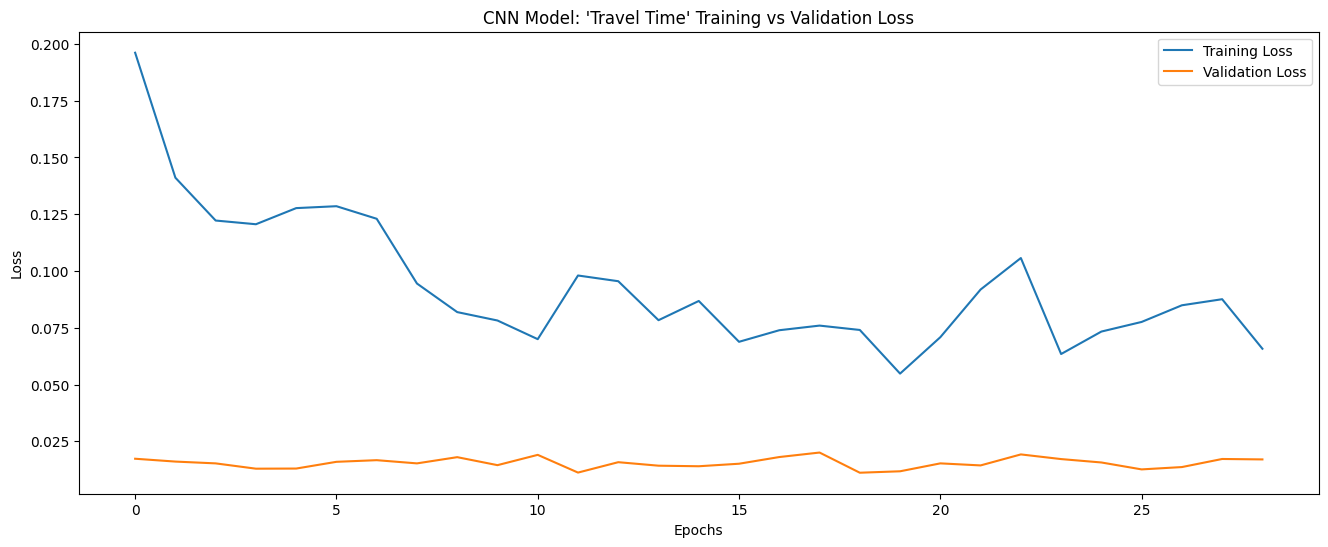

CNN Training Time for 'Travel Time': 15.232 seconds


In [126]:
# Travel Time data
start_time = time()
cnn_history_ttime = model_CNN_t.fit(Xt_train, yt_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                    validation_data=(Xt_val, yt_val), callbacks=[early_stopping])
cnn_time_ttime = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(cnn_history_ttime.history['loss'], label='Training Loss')
plt.plot(cnn_history_ttime.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model: \'Travel Time\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"CNN Training Time for \'Travel Time\': {cnn_time_ttime:.3f} seconds")


#### Predicting using CNN models

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Test: 'Speed' RMSE: 6.691331252541068
CNN Test: 'Speed' MAE: 3.980561357781629


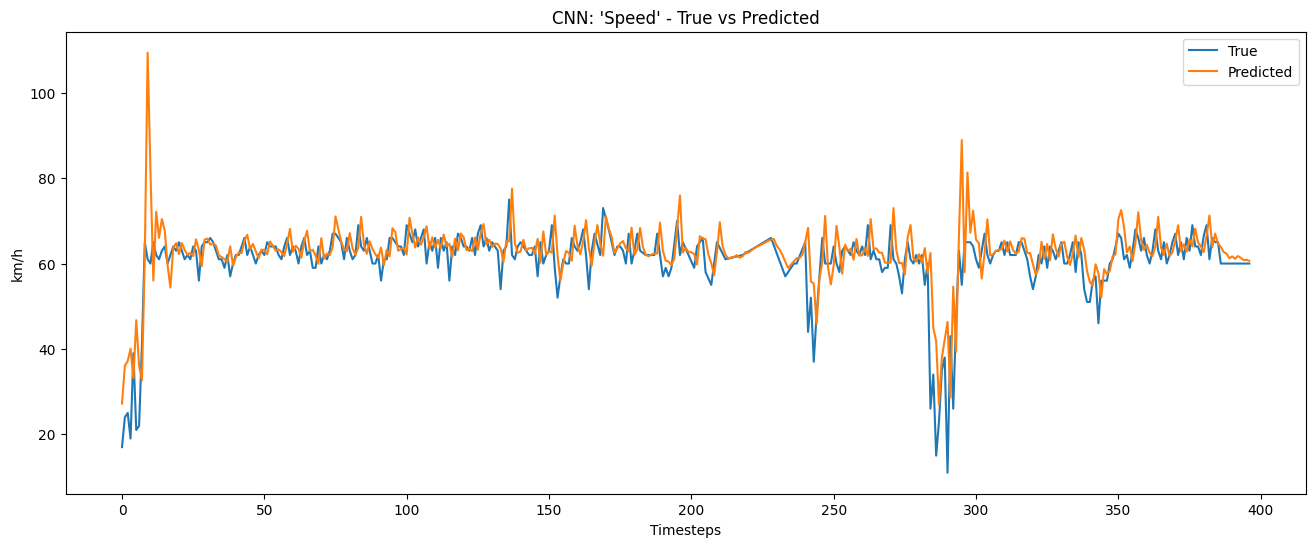

In [127]:
# Evaluate and plot predictions
ys_pred_cnn = model_CNN_s.predict(Xs_test)
# Rescale to original units
ys_pred_cnn_rescale = scaler_sy.inverse_transform(ys_pred_cnn)
# Calculate RMSE and MAE
cnn_rmse_s = np.sqrt(mean_squared_error(ys_test, ys_pred_cnn_rescale))
cnn_mae_s = mean_absolute_error(ys_test, ys_pred_cnn_rescale)

print(f'CNN Test: \'Speed\' RMSE: {cnn_rmse_s}')
print(f'CNN Test: \'Speed\' MAE: {cnn_mae_s}')

plt.figure(figsize=(16,6))
plt.plot(ys_test, label='True')
plt.plot(ys_pred_cnn_rescale, label='Predicted')
plt.title('CNN: \'Speed\' - True vs Predicted')
plt.ylabel('km/h')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
CNN Test: 'Occupancy' RMSE: 4.573052836833971
CNN Test: 'Occupancy' MAE: 3.0019219195572497


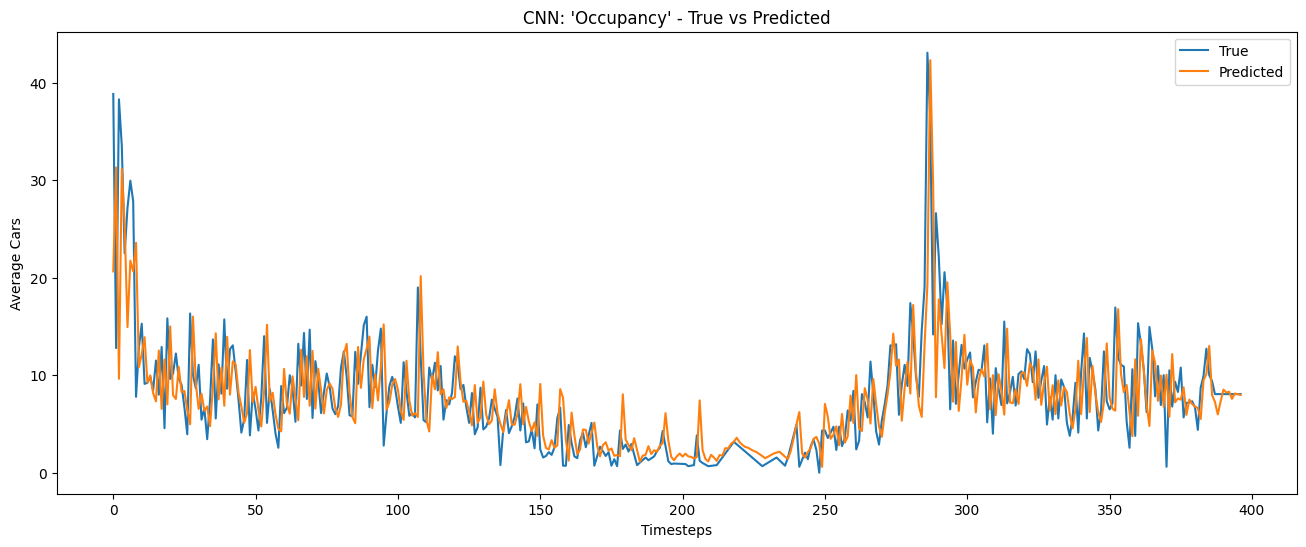

In [128]:
# Evaluate and plot predictions
yo_pred_cnn = model_CNN_o.predict(Xo_test)
# Rescale to original units
yo_pred_cnn_rescale = scaler_oy.inverse_transform(yo_pred_cnn)
# Calculate RMSE and MAE
cnn_rmse_o = np.sqrt(mean_squared_error(yo_test, yo_pred_cnn_rescale))
cnn_mae_o = mean_absolute_error(yo_test, yo_pred_cnn_rescale)

print(f'CNN Test: \'Occupancy\' RMSE: {cnn_rmse_o}')
print(f'CNN Test: \'Occupancy\' MAE: {cnn_mae_o}')

plt.figure(figsize=(16,6))
plt.plot(yo_test, label='True')
plt.plot(yo_pred_cnn_rescale, label='Predicted')
plt.title('CNN: \'Occupancy\' - True vs Predicted')
plt.ylabel('Average Cars')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
CNN Test: 'Travel Time' RMSE: 33.57339887241544
CNN Test: 'Travel Time' MAE: 15.088016925018811


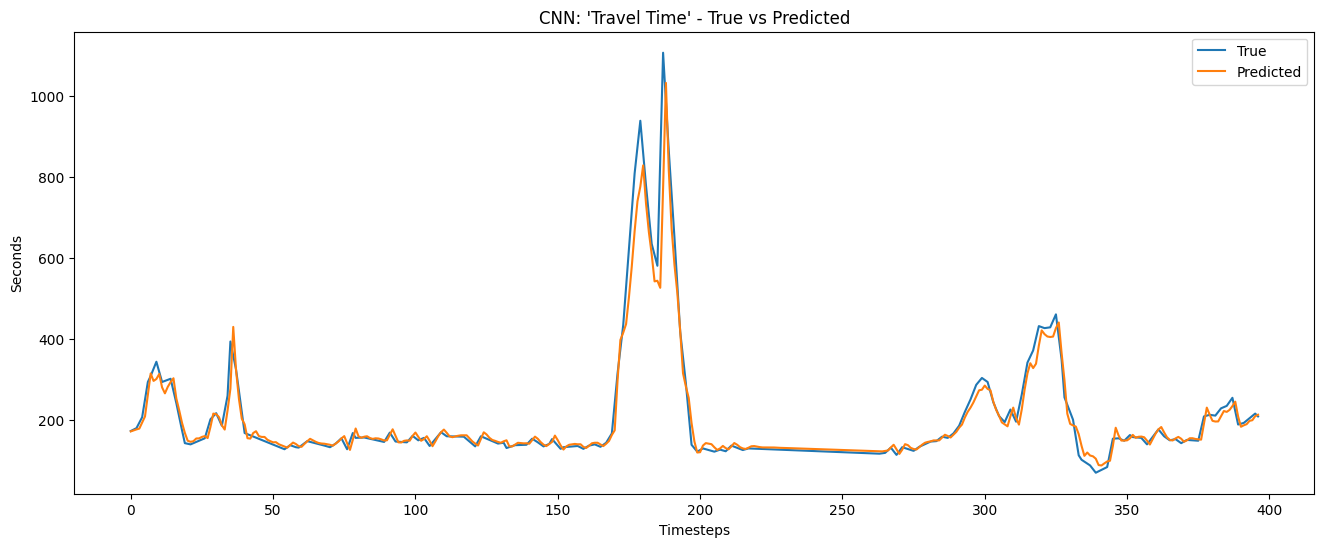

In [129]:
# Evaluate and plot predictions
yt_pred_cnn = model_CNN_t.predict(Xt_test)
# Rescale to original units
yt_pred_cnn_rescale = scaler_ty.inverse_transform(yt_pred_cnn)
# Calculate RMSE and MAE
cnn_rmse_t = np.sqrt(mean_squared_error(yt_test, yt_pred_cnn_rescale))
cnn_mae_t = mean_absolute_error(yt_test, yt_pred_cnn_rescale)

print(f'CNN Test: \'Travel Time\' RMSE: {cnn_rmse_t}')
print(f'CNN Test: \'Travel Time\' MAE: {cnn_mae_t}')

plt.figure(figsize=(16,6))
plt.plot(yt_test, label='True')
plt.plot(yt_pred_cnn_rescale, label='Predicted')
plt.title('CNN: \'Travel Time\' - True vs Predicted')
plt.ylabel('Seconds')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

### RNN Model
Make the model:

In [141]:
# RNN model
model_RNN = Sequential([
    SimpleRNN(40, activation='relu', input_shape=(Xo_train.shape[1], 1)),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Optimizer and loss fn
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
optimizer = Adam(learning_rate=0.00005)
model_RNN.compile(optimizer=optimizer, loss='mean_squared_error')

# Copy models for each variable
model_RNN_s, model_RNN_o, model_RNN_t = model_RNN, model_RNN, model_RNN

# Choose parameters for training
EPOCHS = 100
BATCH_SIZE = 32


#### Training using RNN models

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.8908 - val_loss: 2.4052
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.9133 - val_loss: 2.2892
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9277 - val_loss: 2.1745
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8238 - val_loss: 2.0779
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8156 - val_loss: 2.0032
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8293 - val_loss: 1.9303
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7766 - val_loss: 1.8601
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7319 - val_loss: 1.8018
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7379 - val_loss: 1.7626
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6798 - val_loss: 1.7179
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6591 - val_loss: 1.6764
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss

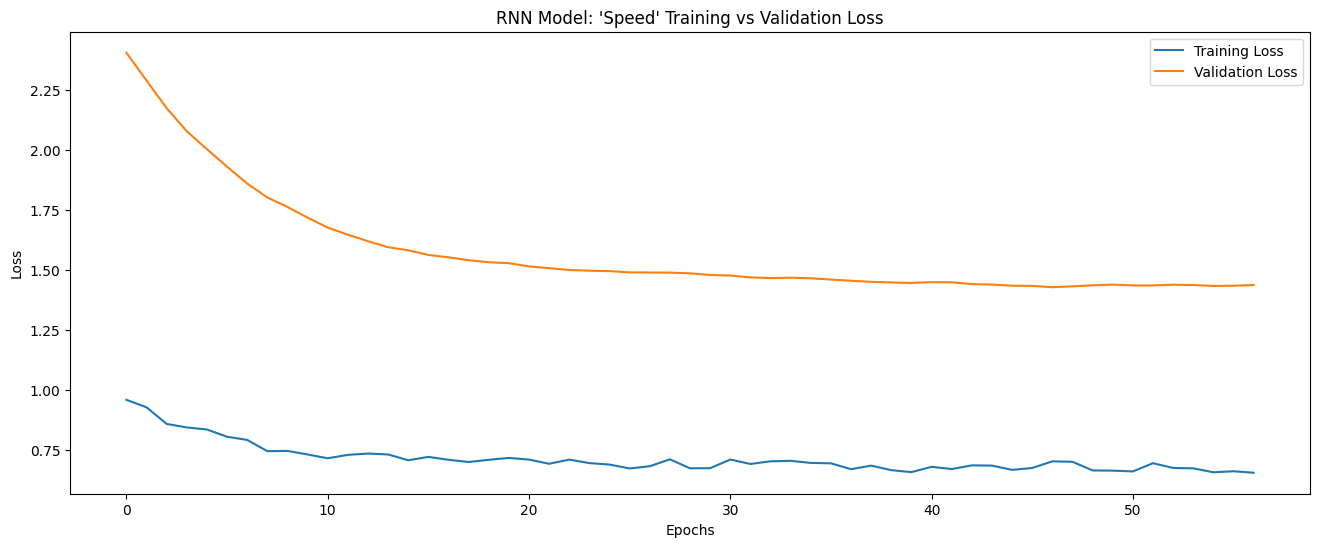

RNN Training Time for 'Speed': 42.384 seconds


In [142]:
# Speed data
start_time = time()
rnn_history_speed = model_RNN_s.fit(Xs_train, ys_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                    validation_data=(Xs_val, ys_val), callbacks=[early_stopping])
rnn_time_speed = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(rnn_history_speed.history['loss'], label='Training Loss')
plt.plot(rnn_history_speed.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Model: \'Speed\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"RNN Training Time for \'Speed\': {rnn_time_speed:.3f} seconds")


Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4540 - val_loss: 0.5750
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4969 - val_loss: 0.5579
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4734 - val_loss: 0.5484
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4421 - val_loss: 0.5410
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4413 - val_loss: 0.5344
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4315 - val_loss: 0.5343
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4497 - val_loss: 0.5317
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4470 - val_loss: 0.5290
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4729 - val_loss: 0.5263
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4521 - val_loss: 0.5279
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4731 - val_loss: 0.5268
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 

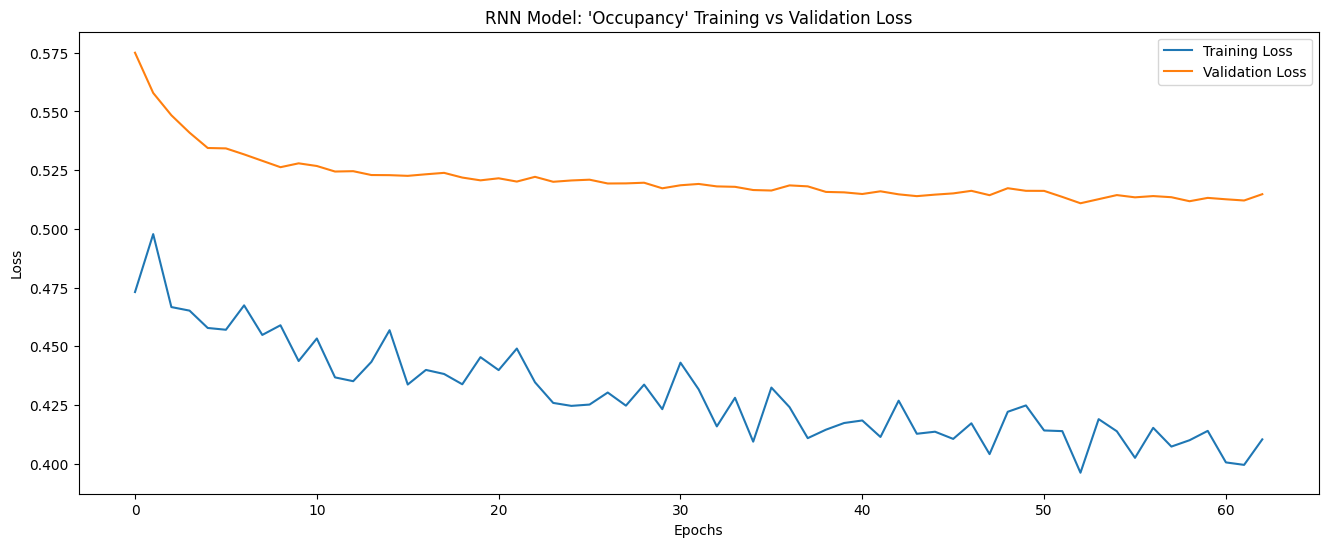

RNN Training Time for 'Occupancy': 36.163 seconds


In [143]:
# Occupancy data
start_time = time()
rnn_history_occupancy = model_RNN_o.fit(Xo_train, yo_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                        validation_data=(Xo_val, yo_val), callbacks=[early_stopping])
rnn_time_occupancy = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(rnn_history_occupancy.history['loss'], label='Training Loss')
plt.plot(rnn_history_occupancy.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Model: \'Occupancy\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"RNN Training Time for \'Occupancy\': {rnn_time_occupancy:.3f} seconds")

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5425 - val_loss: 0.0211
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2411 - val_loss: 0.0204
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2135 - val_loss: 0.0202
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2599 - val_loss: 0.0194
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2805 - val_loss: 0.0189
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1850 - val_loss: 0.0182
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2512 - val_loss: 0.0180
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1939 - val_loss: 0.0178
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1472 - val_loss: 0.0175
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1867 - val_loss: 0.0175
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1688 - val_loss: 0.0173
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0

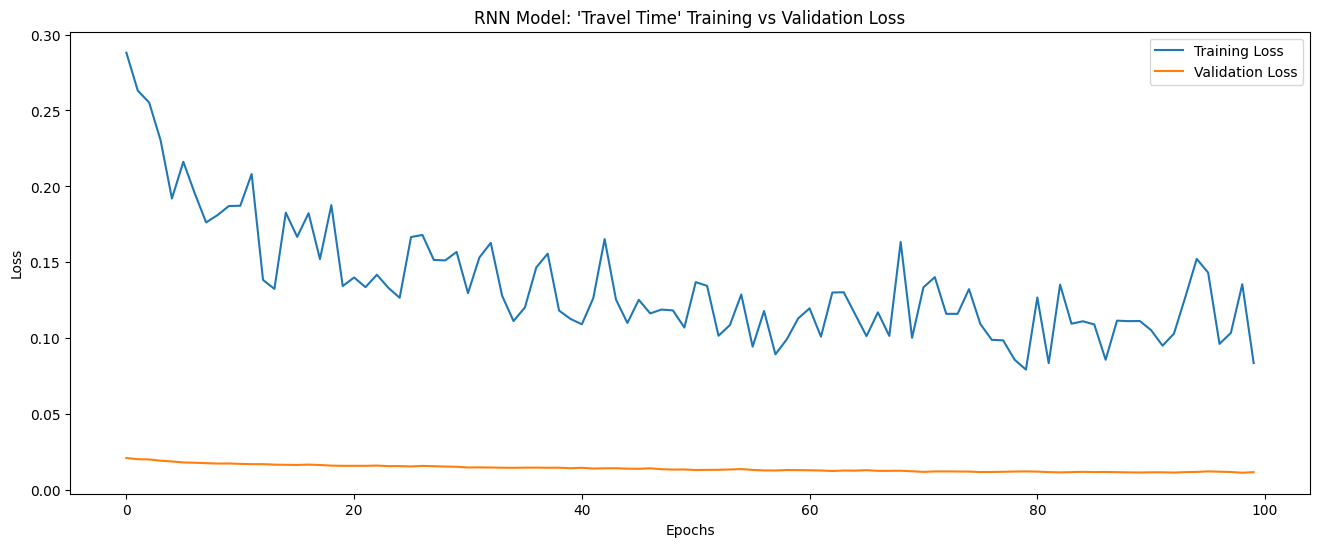

RNN Training Time for 'Travel Time': 60.404 seconds


In [144]:
# Travel Time data
start_time = time()
rnn_history_ttime = model_RNN_t.fit(Xt_train, yt_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                    validation_data=(Xt_val, yt_val), callbacks=[early_stopping])
rnn_time_ttime = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(rnn_history_ttime.history['loss'], label='Training Loss')
plt.plot(rnn_history_ttime.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Model: \'Travel Time\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"RNN Training Time for \'Travel Time\': {rnn_time_ttime:.3f} seconds")


#### Predicting using RNN Models

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
RNN Test: 'Speed' RMSE: 5.247632802772416
RNN Test: 'Speed' MAE: 3.3602028085242592


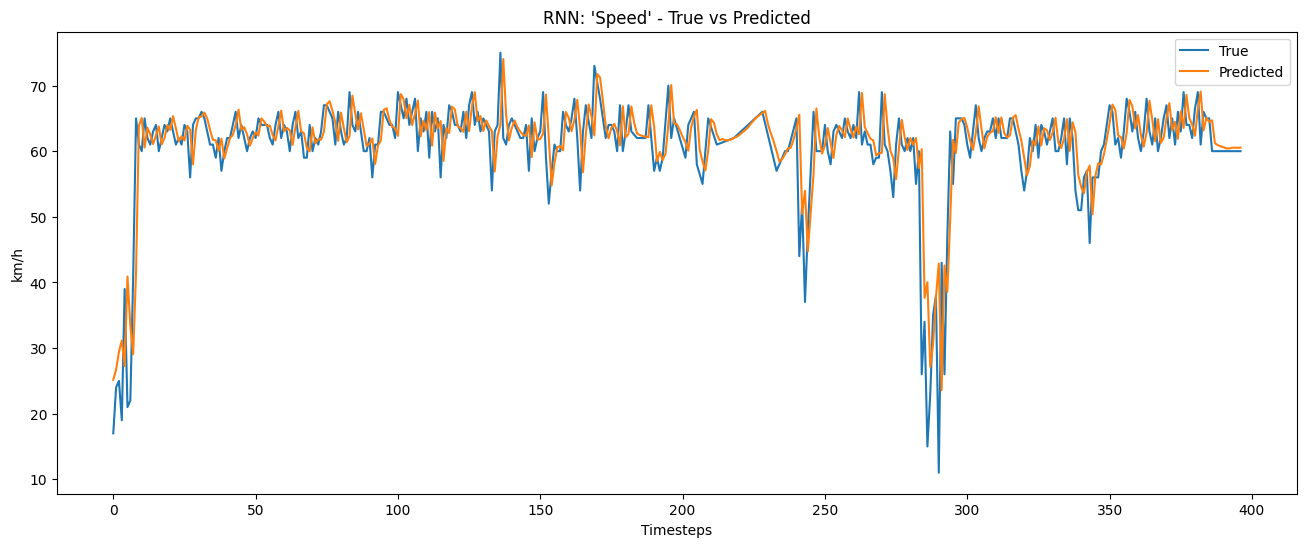

In [145]:
# Evaluate and plot predictions
ys_pred_rnn = model_RNN_s.predict(Xs_test)
# Rescale to original units
ys_pred_rnn_rescale = scaler_sy.inverse_transform(ys_pred_rnn.reshape(-1, 1))
# Calculate RMSE and MAE
rnn_rmse_s = np.sqrt(mean_squared_error(ys_test, ys_pred_rnn_rescale))
rnn_mae_s = mean_absolute_error(ys_test, ys_pred_rnn_rescale)

print(f'RNN Test: \'Speed\' RMSE: {rnn_rmse_s}')
print(f'RNN Test: \'Speed\' MAE: {rnn_mae_s}')

plt.figure(figsize=(16,6))
plt.plot(ys_test, label='True')
plt.plot(ys_pred_rnn_rescale, label='Predicted')
plt.title('RNN: \'Speed\' - True vs Predicted')
plt.ylabel('km/h')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RNN Test: 'Occupancy' RMSE: 4.4834895789611995
RNN Test: 'Occupancy' MAE: 2.9431503494560567


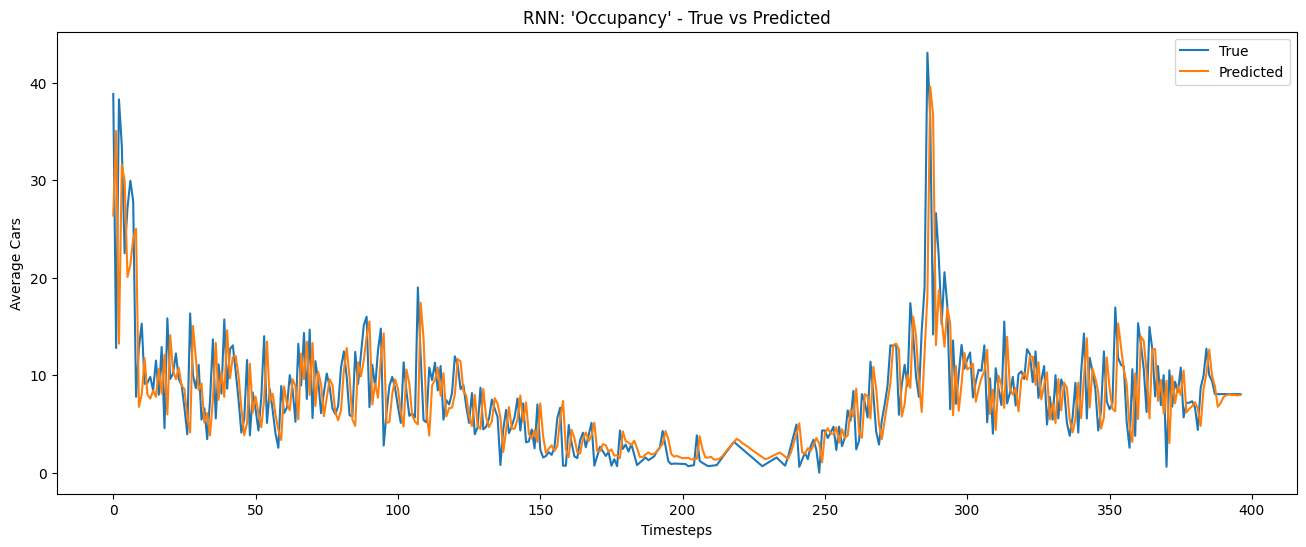

In [146]:
# Evaluate and plot predictions
yo_pred_rnn = model_RNN_o.predict(Xo_test)
# Rescale to original units
yo_pred_rnn_rescale = scaler_oy.inverse_transform(yo_pred_rnn)
# Calculate RMSE and MAE
rnn_rmse_o = np.sqrt(mean_squared_error(yo_test, yo_pred_rnn_rescale))
rnn_mae_o = mean_absolute_error(yo_test, yo_pred_rnn_rescale)

print(f'RNN Test: \'Occupancy\' RMSE: {rnn_rmse_o}')
print(f'RNN Test: \'Occupancy\' MAE: {rnn_mae_o}')

plt.figure(figsize=(16,6))
plt.plot(yo_test, label='True')
plt.plot(yo_pred_rnn_rescale, label='Predicted')
plt.title('RNN: \'Occupancy\' - True vs Predicted')
plt.ylabel('Average Cars')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RNN Test: 'Travel Time' RMSE: 32.65727135133257
RNN Test: 'Travel Time' MAE: 13.462613886718456


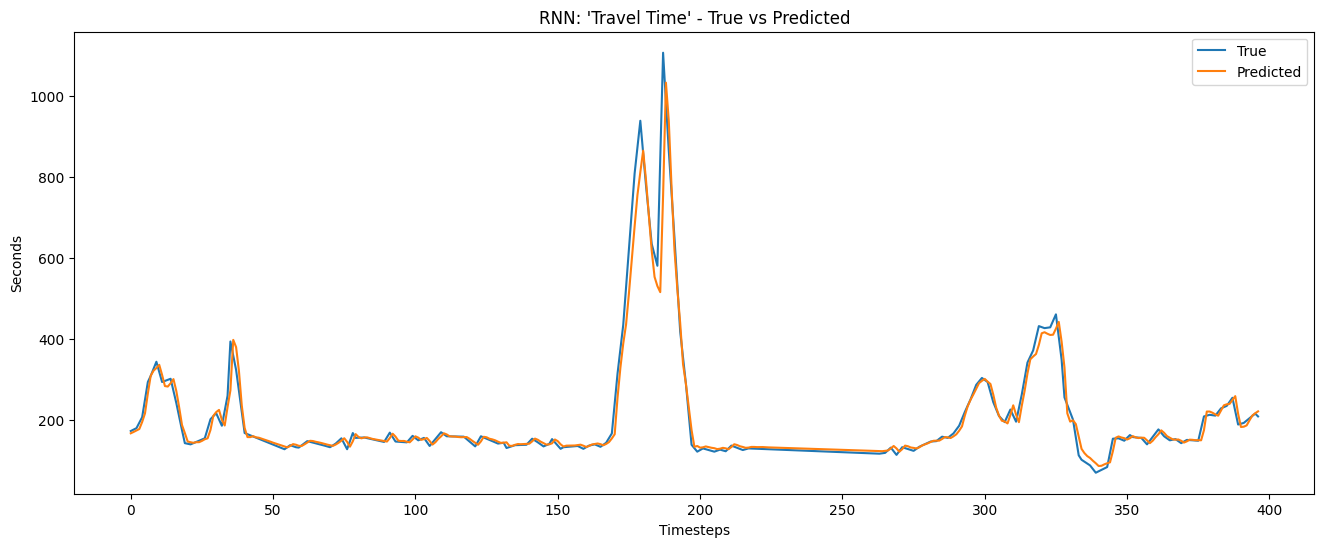

In [147]:
# Evaluate and plot predictions
yt_pred_rnn = model_RNN_t.predict(Xt_test)
# Rescale to original units
yt_pred_rnn_rescale = scaler_ty.inverse_transform(yt_pred_rnn)
# Calculate RMSE and MAE
rnn_rmse_t = np.sqrt(mean_squared_error(yt_test, yt_pred_rnn_rescale))
rnn_mae_t = mean_absolute_error(yt_test, yt_pred_rnn_rescale)

print(f'RNN Test: \'Travel Time\' RMSE: {rnn_rmse_t}')
print(f'RNN Test: \'Travel Time\' MAE: {rnn_mae_t}')

plt.figure(figsize=(16,6))
plt.plot(yt_test, label='True')
plt.plot(yt_pred_rnn_rescale, label='Predicted')
plt.title('RNN: \'Travel Time\' - True vs Predicted')
plt.ylabel('Seconds')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

### LTSM Model
Make the model:

In [99]:
# LSTM model
model_LSTM = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(Xs_train.shape[1], 1),
         recurrent_dropout=0.1),
    LSTM(64, activation='relu', return_sequences=True, recurrent_dropout=0.1),
    LSTM(48, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# Optimizer and loss fn
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
optimizer = Adam(learning_rate=0.0001)
model_LSTM.compile(optimizer=optimizer, loss='mse')

# Copy models for each variable
model_LSTM_s, model_LSTM_o, model_LSTM_t = model_LSTM, model_LSTM, model_LSTM

# Choose parameters for training
EPOCHS = 100
BATCH_SIZE = 32


#### Training LSTM models

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 1.0121 - val_loss: 2.5105
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.9759 - val_loss: 2.4766
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.9515 - val_loss: 2.4375
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.8452 - val_loss: 2.3810
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.8801 - val_loss: 2.3772
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.8231 - val_loss: 2.3394
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.8865 - val_loss: 2.2781
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.8822 - val_loss: 2.2645
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.8745 - val_loss: 2.2653
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.8035 - val_loss: 2.2275
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.8234 - val_loss: 2.2116
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/st

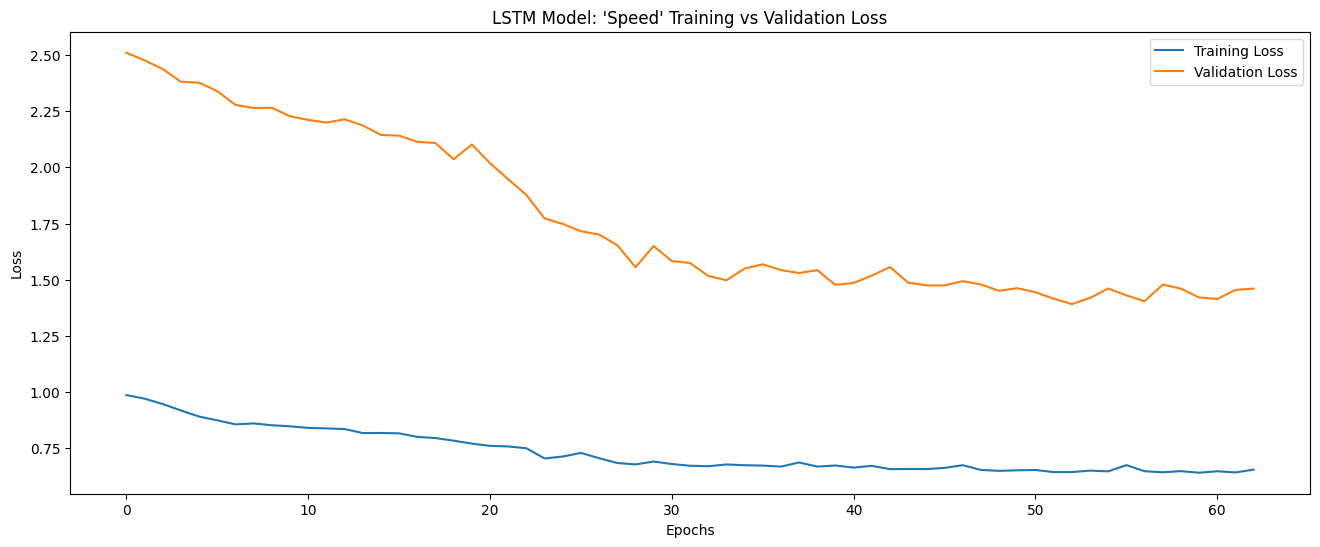

LSTM Training Time for 'Speed': 183.003 seconds


In [100]:
# Speed data
start_time = time()
lstm_history_speed = model_LSTM_s.fit(Xs_train, ys_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                      validation_data=(Xs_val, ys_val), callbacks=[early_stopping])
lstm_time_speed = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(lstm_history_speed.history['loss'], label='Training Loss')
plt.plot(lstm_history_speed.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model: \'Speed\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"LSTM Training Time for \'Speed\': {lstm_time_speed:.3f} seconds")


Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.4606 - val_loss: 0.4933
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.3990 - val_loss: 0.4917
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.3830 - val_loss: 0.4950
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.3816 - val_loss: 0.4952
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.3630 - val_loss: 0.4888
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.3955 - val_loss: 0.4874
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.3565 - val_loss: 0.4946
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.3629 - val_loss: 0.4918
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.3911 - val_loss: 0.4869
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.3820 - val_loss: 0.4959
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.3903 - val_loss: 0.4916
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/s

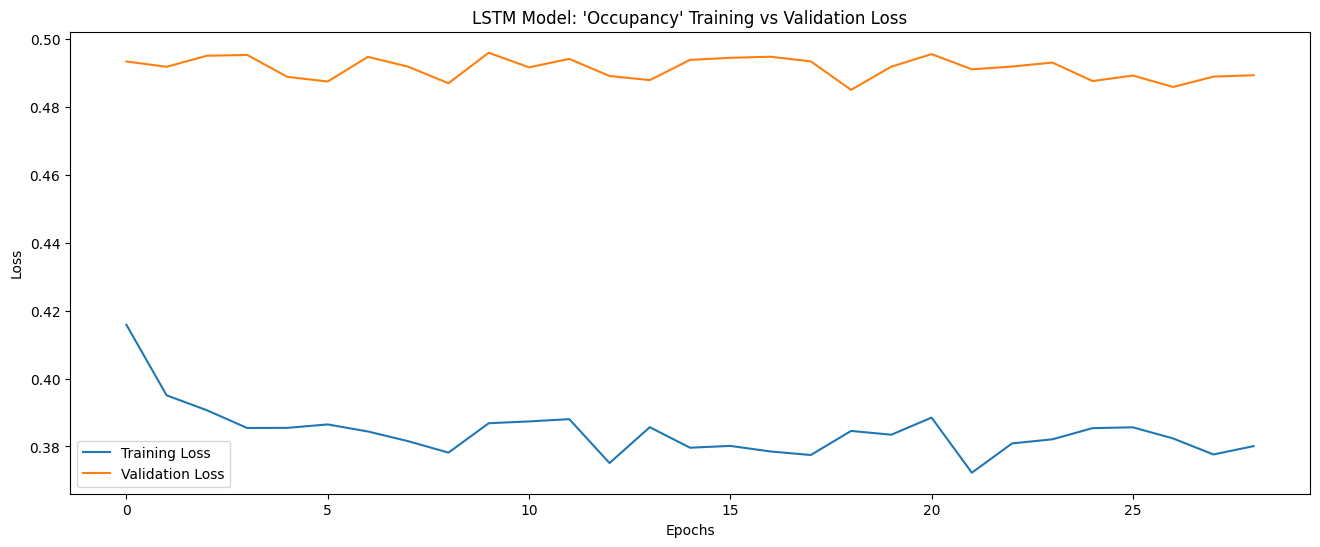

LSTM Training Time for 'Occupancy': 82.880 seconds


In [101]:
# Occupancy data
start_time = time()
lstm_history_occupancy = model_LSTM_o.fit(Xo_train, yo_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                          validation_data=(Xo_val, yo_val), callbacks=[early_stopping])
lstm_time_occupancy = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(lstm_history_occupancy.history['loss'], label='Training Loss')
plt.plot(lstm_history_occupancy.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model: \'Occupancy\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"LSTM Training Time for \'Occupancy\': {lstm_time_occupancy:.3f} seconds")


Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.3771 - val_loss: 0.0639
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.3012 - val_loss: 0.0332
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.1587 - val_loss: 0.0271
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.1623 - val_loss: 0.0156
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.1382 - val_loss: 0.0143
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.1498 - val_loss: 0.0152
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.1090 - val_loss: 0.0158
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0927 - val_loss: 0.0140
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.1128 - val_loss: 0.0131
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.1100 - val_loss: 0.0168
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.1311 - val_loss: 0.0145
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/st

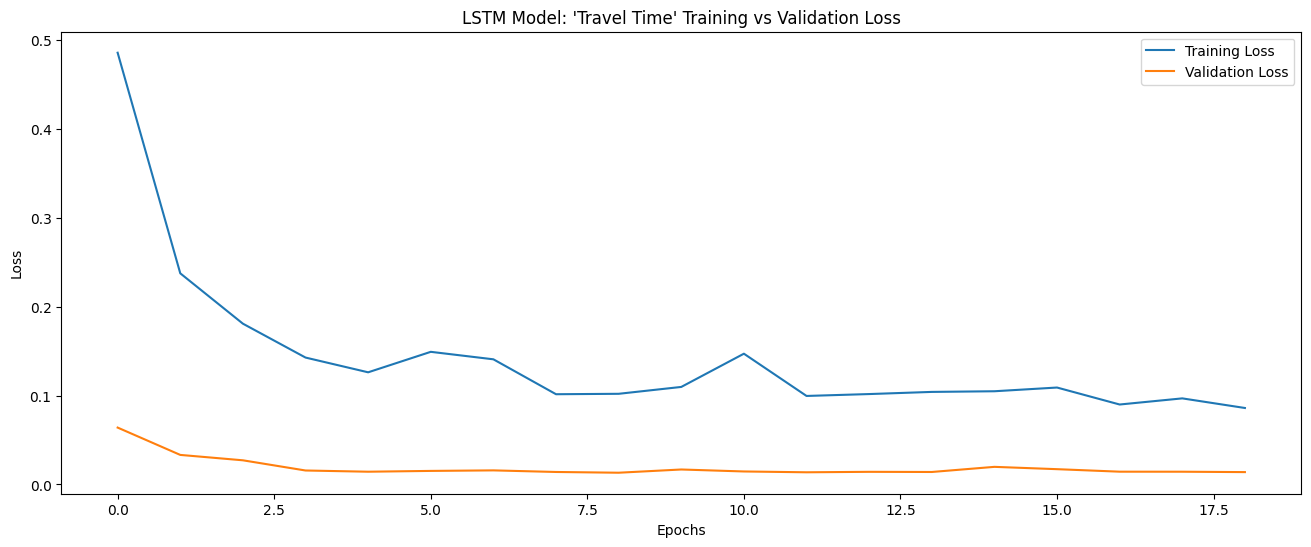

LSTM Training Time for 'Travel Time': 56.634 seconds


In [102]:
# Travel Time data
start_time = time()
lstm_history_ttime = model_LSTM_t.fit(Xt_train, yt_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                      validation_data=(Xt_val, yt_val), callbacks=[early_stopping])
lstm_time_ttime = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(lstm_history_ttime.history['loss'], label='Training Loss')
plt.plot(lstm_history_ttime.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model: \'Travel Time\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"LSTM Training Time for \'Travel Time\': {lstm_time_ttime:.3f} seconds")


#### Predicting using LSTM models

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
LSTM Test: 'Speed' RMSE: 7.660730020344793
LSTM Test: 'Speed' MAE: 4.035950072166001


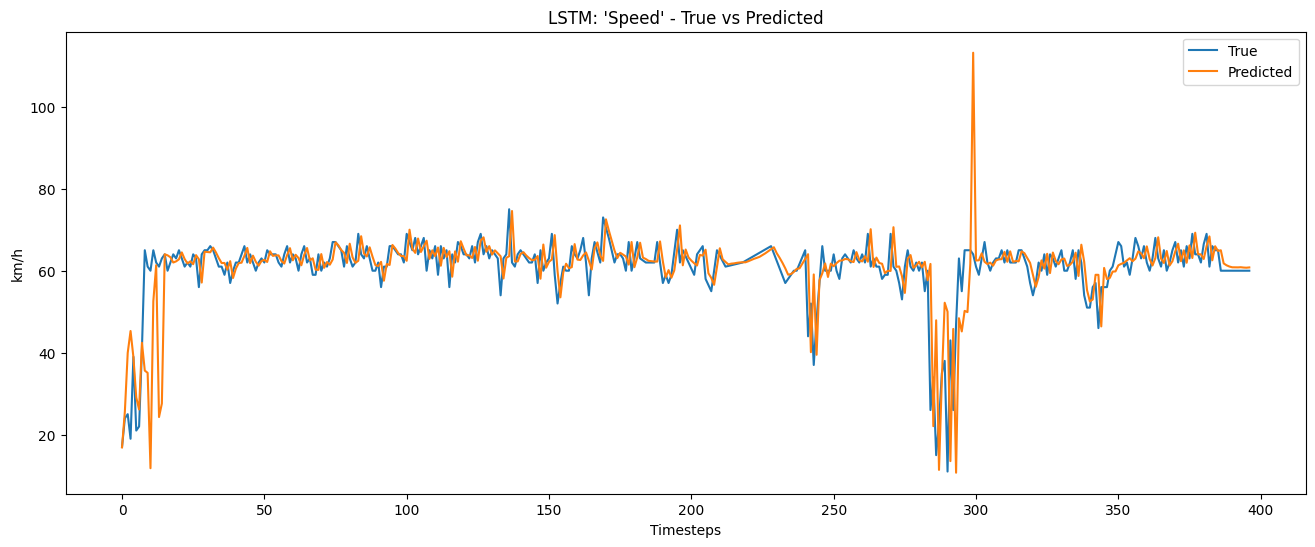

In [103]:
# Evaluate and plot predictions
ys_pred_lstm = model_LSTM_s.predict(Xs_test)
# Rescale to original units
ys_pred_lstm_rescale = scaler_sy.inverse_transform(ys_pred_lstm)
# Calculate RMSE and MAE
lstm_rmse_s = np.sqrt(mean_squared_error(ys_test, ys_pred_lstm_rescale))
lstm_mae_s = mean_absolute_error(ys_test, ys_pred_lstm_rescale)

print(f'LSTM Test: \'Speed\' RMSE: {lstm_rmse_s}')
print(f'LSTM Test: \'Speed\' MAE: {lstm_mae_s}')

# Visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16,6))
plt.plot(ys_test, label='True')
plt.plot(ys_pred_lstm_rescale, label='Predicted')
plt.title('LSTM: \'Speed\' - True vs Predicted')
plt.ylabel('km/h')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
LSTM Test: 'Occupancy' RMSE: 4.210818409579491
LSTM Test: 'Occupancy' MAE: 2.7921392747637204


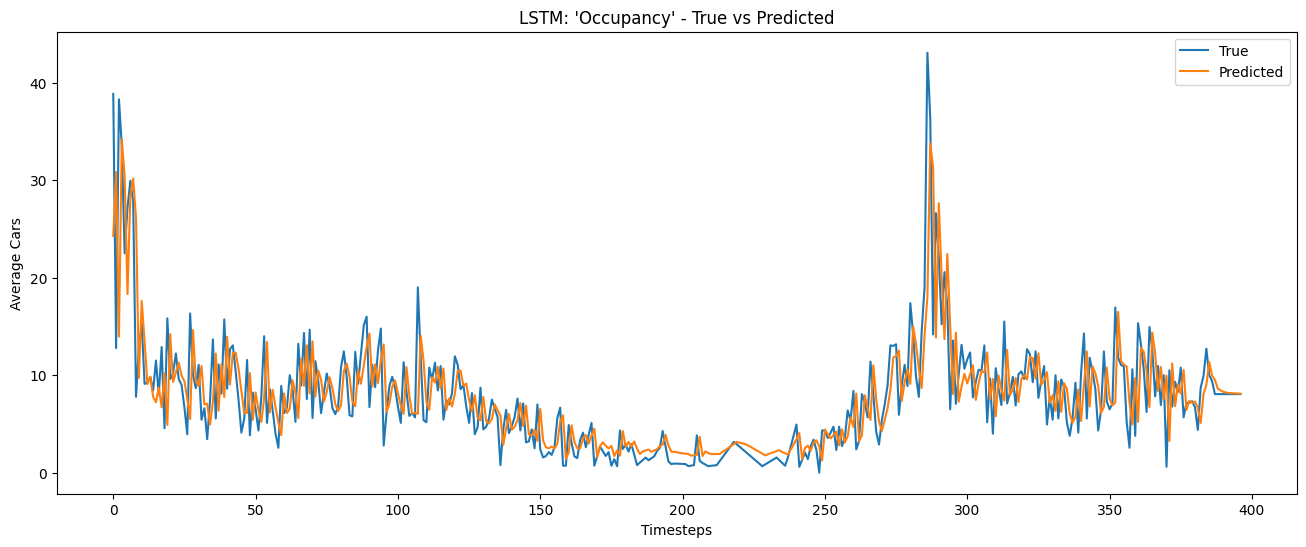

In [104]:
# Evaluate and plot predictions
yo_pred_lstm = model_LSTM_o.predict(Xo_test)
# Rescale to original units
yo_pred_lstm_rescale = scaler_oy.inverse_transform(yo_pred_lstm)
# Calculate RMSE and MAE
lstm_rmse_o = np.sqrt(mean_squared_error(yo_test, yo_pred_lstm_rescale))
lstm_mae_o = mean_absolute_error(yo_test, yo_pred_lstm_rescale)

print(f'LSTM Test: \'Occupancy\' RMSE: {lstm_rmse_o}')
print(f'LSTM Test: \'Occupancy\' MAE: {lstm_mae_o}')

# Visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16,6))
plt.plot(yo_test, label='True')
plt.plot(yo_pred_lstm_rescale, label='Predicted')
plt.title('LSTM: \'Occupancy\' - True vs Predicted')
plt.ylabel('Average Cars')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
LSTM Test: 'Travel Time' RMSE: 37.25872334117548
LSTM Test: 'Travel Time' MAE: 18.697994919527886


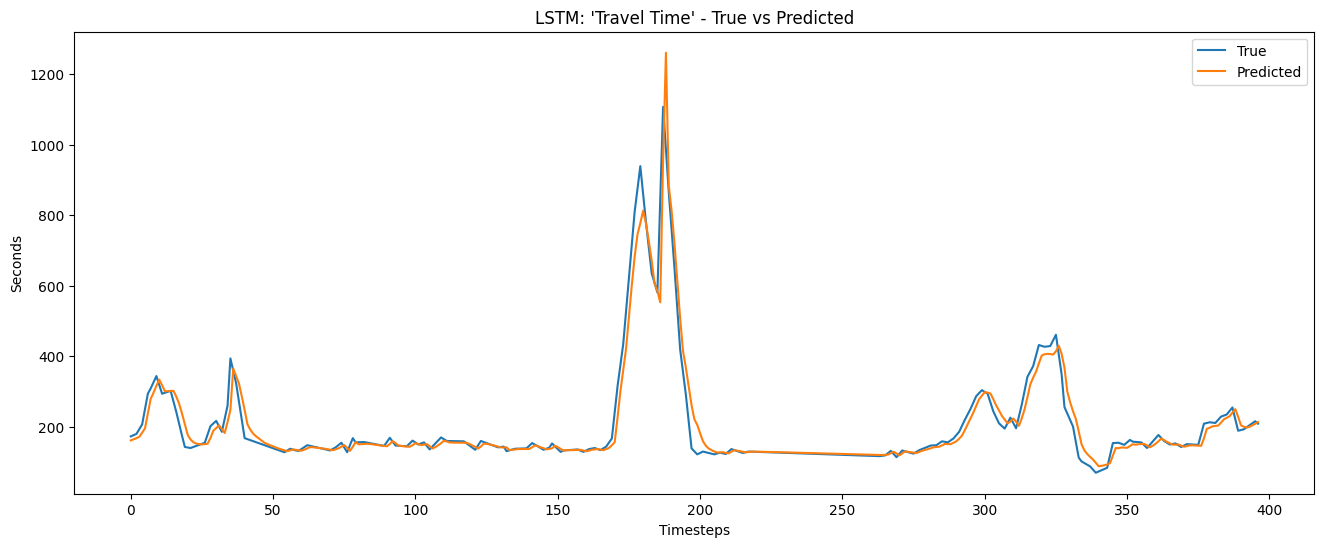

In [105]:
# Evaluate and plot predictions
yt_pred_lstm = model_LSTM_t.predict(Xt_test)
# Rescale to original units
yt_pred_lstm_rescale = scaler_ty.inverse_transform(yt_pred_lstm)
# Calculate RMSE and MAE
lstm_rmse_t = np.sqrt(mean_squared_error(yt_test, yt_pred_lstm_rescale))
lstm_mae_t = mean_absolute_error(yt_test, yt_pred_lstm_rescale)

print(f'LSTM Test: \'Travel Time\' RMSE: {lstm_rmse_t}')
print(f'LSTM Test: \'Travel Time\' MAE: {lstm_mae_t}')

# Visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16,6))
plt.plot(yt_test, label='True')
plt.plot(yt_pred_lstm_rescale, label='Predicted')
plt.title('LSTM: \'Travel Time\' - True vs Predicted')
plt.ylabel('Seconds')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

### GRU Model
Make the model:

In [109]:
# GRU Model
model_GRU = Sequential([
    tf.keras.layers.GRU(128, activation='relu', return_sequences=True,
                                  input_shape=(Xs_train.shape[1], 1), recurrent_dropout=0.1),
    tf.keras.layers.GRU(128, activation='relu', return_sequences=True),
    tf.keras.layers.GRU(64, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

# Optimizer and loss fn
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
optimizer = Adam(learning_rate=0.0001)
model_GRU.compile(optimizer=optimizer, loss='mse')

# Copy models for each variable
model_GRU_s, model_GRU_o, model_GRU_t = model_GRU, model_GRU, model_GRU

# Choose parameters for training
EPOCHS = 100
BATCH_SIZE = 32



#### Training GRU models

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.9202 - val_loss: 2.3274
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.8467 - val_loss: 2.1377
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.7927 - val_loss: 2.0503
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.7644 - val_loss: 1.9487
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 0.6908 - val_loss: 1.8249
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.6691 - val_loss: 1.6900
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.6535 - val_loss: 1.6114
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.6355 - val_loss: 1.5796
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.6713 - val_loss: 1.5608
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.6128 - val_loss: 1.5481
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.6387 - val_loss: 1.5393
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/s

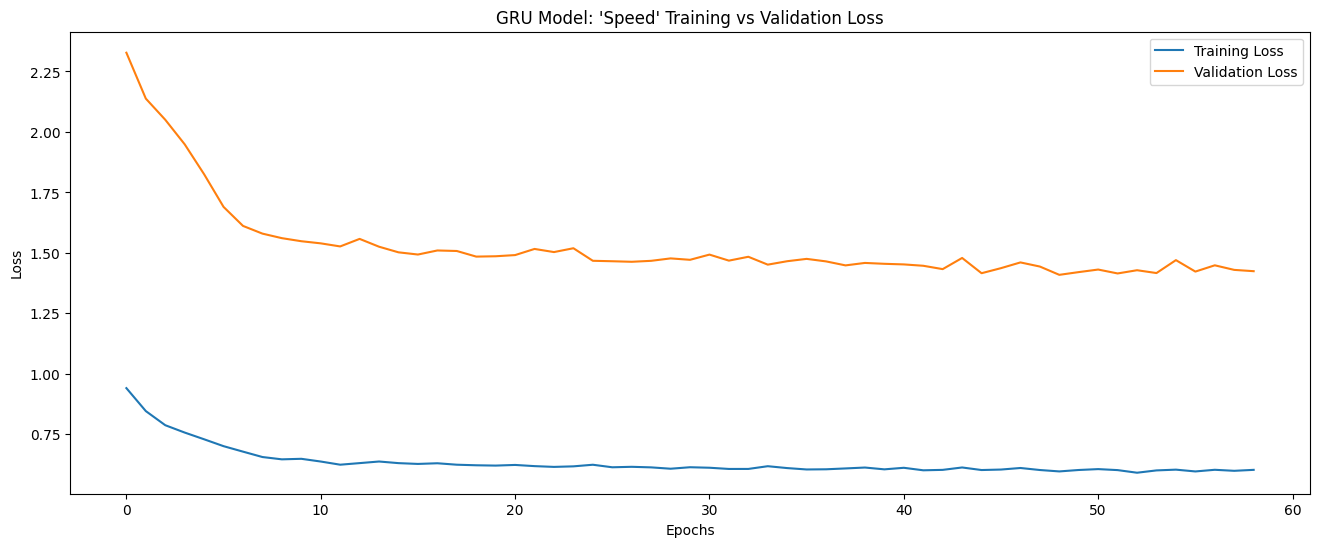

GRU Training Time for 'Speed': 352.298 seconds


In [110]:
# Speed data
start_time = time()
gru_history_speed = model_GRU_s.fit(Xs_train, ys_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                    validation_data=(Xs_val, ys_val), callbacks=[early_stopping])
gru_time_speed = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(gru_history_speed.history['loss'], label='Training Loss')
plt.plot(gru_history_speed.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU Model: \'Speed\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"GRU Training Time for \'Speed\': {gru_time_speed:.3f} seconds")

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.3710 - val_loss: 0.5140
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.3627 - val_loss: 0.5266
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.3975 - val_loss: 0.5209
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.3448 - val_loss: 0.5308
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.3664 - val_loss: 0.5145
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.3906 - val_loss: 0.5135
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.3537 - val_loss: 0.5101
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.3476 - val_loss: 0.5078
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.3764 - val_loss: 0.5088
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.3913 - val_loss: 0.5132


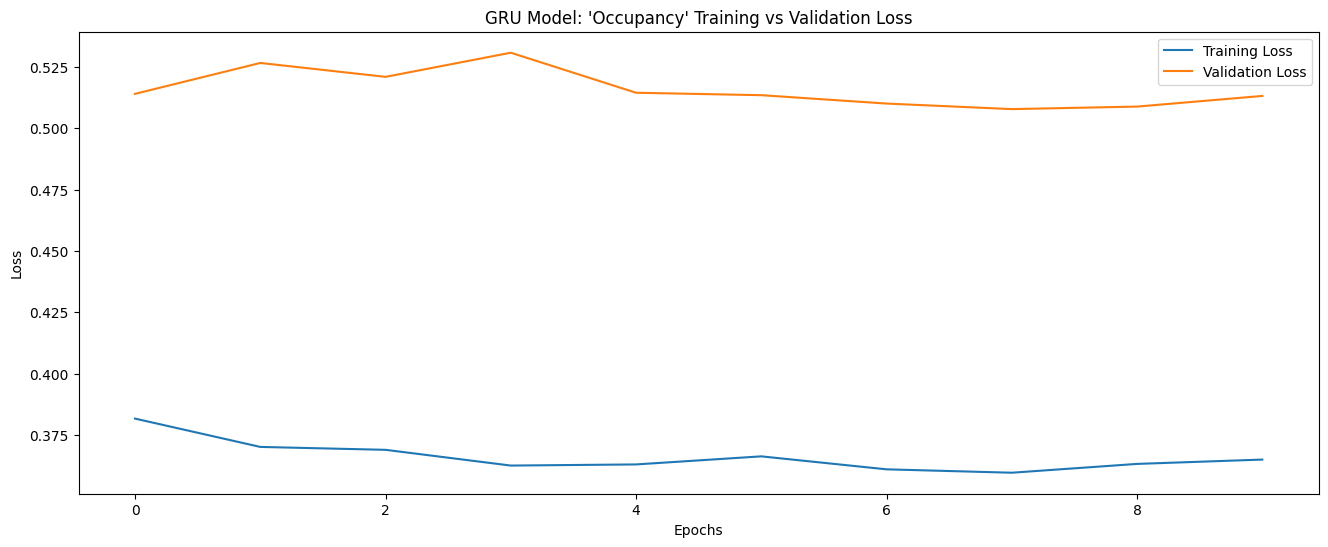

GRU Training Time for 'Occupancy': 42.045 seconds


In [151]:
# Occupancy data
start_time = time()
gru_history_occupancy = model_GRU_o.fit(Xo_train, yo_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                        validation_data=(Xo_val, yo_val), callbacks=[early_stopping])
gru_time_occupancy = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(gru_history_occupancy.history['loss'], label='Training Loss')
plt.plot(gru_history_occupancy.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU Model: \'Occupancy\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"GRU Training Time for \'Occupancy\': {gru_time_occupancy:.3f} seconds")

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.3011 - val_loss: 0.0170
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0772 - val_loss: 0.0135
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.0593 - val_loss: 0.0115
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0618 - val_loss: 0.0108
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0563 - val_loss: 0.0133
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0690 - val_loss: 0.0097
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0485 - val_loss: 0.0084
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0735 - val_loss: 0.0097
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0470 - val_loss: 0.0137
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0429 - val_loss: 0.0084
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0516 - val_loss: 0.0088
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step

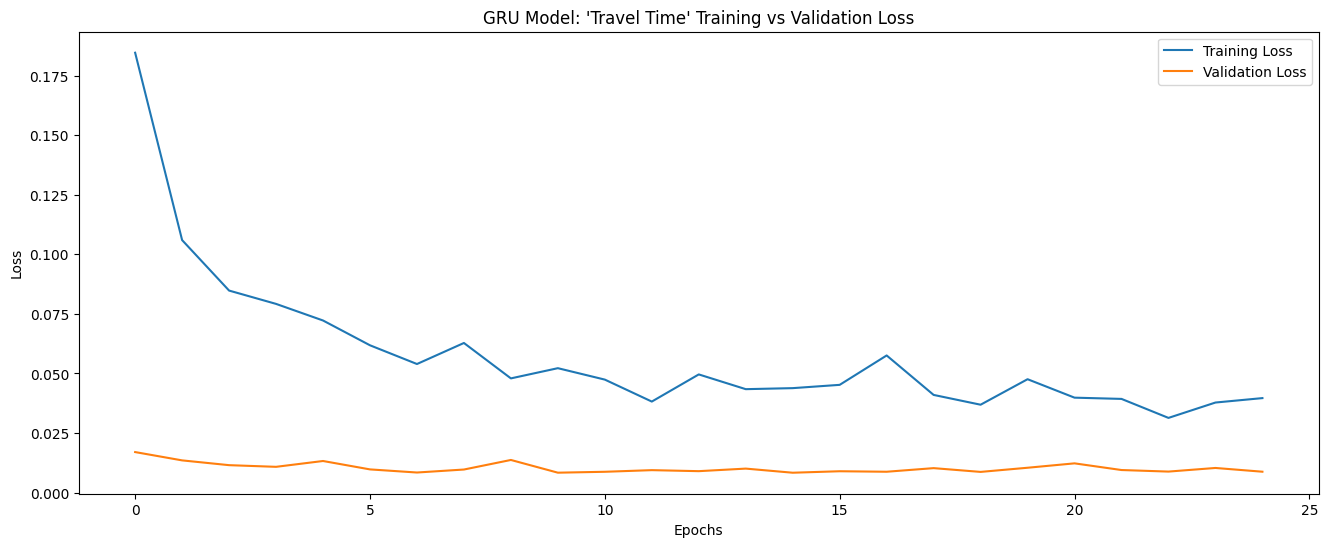

GRU Training Time for 'Travel Time': 114.981 seconds


In [152]:
# Travel Time data
start_time = time()
gru_history_ttime = model_GRU_t.fit(Xt_train, yt_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                    validation_data=(Xt_val, yt_val), callbacks=[early_stopping])
gru_time_ttime = time() - start_time

# Plot training and validation loss
plt.figure(figsize=(16,6))
plt.plot(gru_history_ttime.history['loss'], label='Training Loss')
plt.plot(gru_history_ttime.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU Model: \'Travel Time\' Training vs Validation Loss')
plt.legend()
plt.show()

print(f"GRU Training Time for \'Travel Time\': {gru_time_ttime:.3f} seconds")

#### Predicting using GRU models

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step
GRU Test: 'Speed' RMSE: 24.133259912444178
GRU Test: 'Speed' MAE: 8.749570405353127


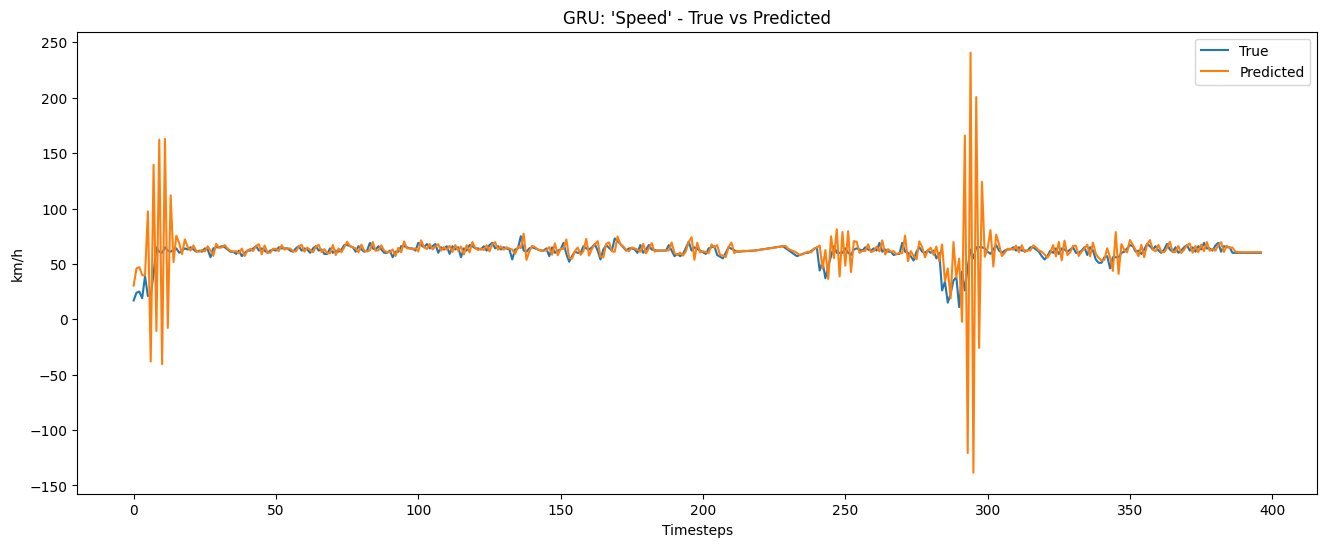

In [153]:
# Evaluate and plot predictions
ys_pred_gru = model_GRU_s.predict(Xs_test)
# Rescale to original units
ys_pred_gru_rescale = scaler_sy.inverse_transform(ys_pred_gru)
# Calculate RMSE and MAE
gru_rmse_s = np.sqrt(mean_squared_error(ys_test, ys_pred_gru_rescale))
gru_mae_s = mean_absolute_error(ys_test, ys_pred_gru_rescale)

print(f'GRU Test: \'Speed\' RMSE: {gru_rmse_s}')
print(f'GRU Test: \'Speed\' MAE: {gru_mae_s}')

# Visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16,6))
plt.plot(ys_test, label='True')
plt.plot(ys_pred_gru_rescale, label='Predicted')
plt.title('GRU: \'Speed\' - True vs Predicted')
plt.ylabel('km/h')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
GRU Test: 'Occupancy' RMSE: 6.027461996815126
GRU Test: 'Occupancy' MAE: 3.5432418156355796


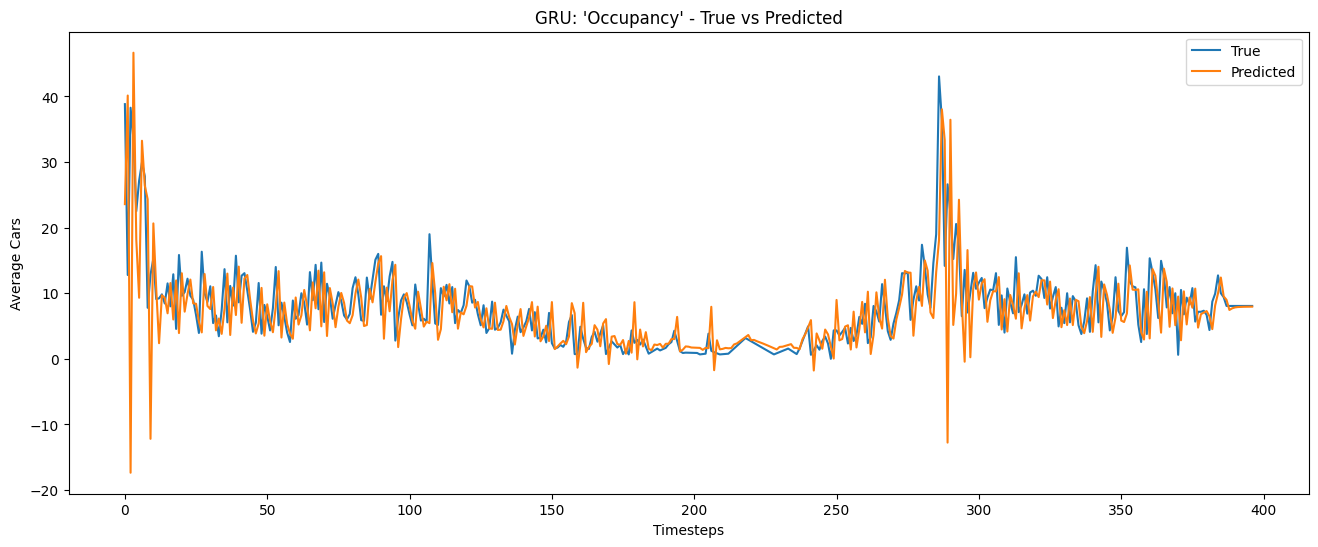

In [154]:
# Evaluate and plot predictions
yo_pred_gru = model_GRU_o.predict(Xo_test)
# Rescale to original units
yo_pred_gru_rescale = scaler_oy.inverse_transform(yo_pred_gru)
# Calculate RMSE and MAE
gru_rmse_o = np.sqrt(mean_squared_error(yo_test, yo_pred_gru_rescale))
gru_mae_o = mean_absolute_error(yo_test, yo_pred_gru_rescale)

print(f'GRU Test: \'Occupancy\' RMSE: {gru_rmse_o}')
print(f'GRU Test: \'Occupancy\' MAE: {gru_mae_o}')

# Visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16,6))
plt.plot(yo_test, label='True')
plt.plot(yo_pred_gru_rescale, label='Predicted')
plt.title('GRU: \'Occupancy\' - True vs Predicted')
plt.ylabel('Average Cars')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
GRU Test: 'Travel Time' RMSE: 27.389738809761653
GRU Test: 'Travel Time' MAE: 11.501279715855686


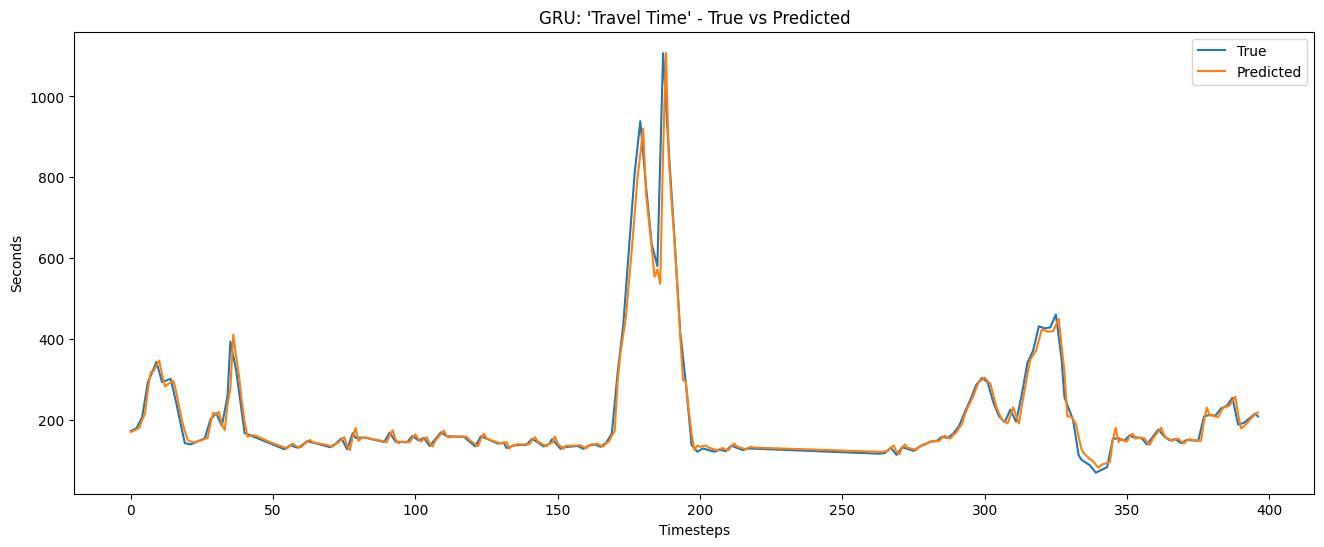

In [155]:
# Evaluate and plot predictions
yt_pred_gru = model_GRU_t.predict(Xt_test)
# Rescale to original units
yt_pred_gru_rescale = scaler_ty.inverse_transform(yt_pred_gru)
# Calculate RMSE and MAE
gru_rmse_t = np.sqrt(mean_squared_error(yt_test, yt_pred_gru_rescale))
gru_mae_t = mean_absolute_error(yt_test, yt_pred_gru_rescale)

print(f'GRU Test: \'Travel Time\' RMSE: {gru_rmse_t}')
print(f'GRU Test: \'Travel Time\' MAE: {gru_mae_t}')

# Visualize the model's predictions with the predicted data and the actual test data
plt.figure(figsize=(16,6))
plt.plot(yt_test, label='True')
plt.plot(yt_pred_gru_rescale, label='Predicted')
plt.title('GRU: \'Travel Time\' - True vs Predicted')
plt.ylabel('Seconds')
plt.xlabel('Timesteps')
plt.legend()
plt.show()

## 3. Model Performances and Tuning
- Compare performances to select model
- Hyperparameter tuning

### Model performances

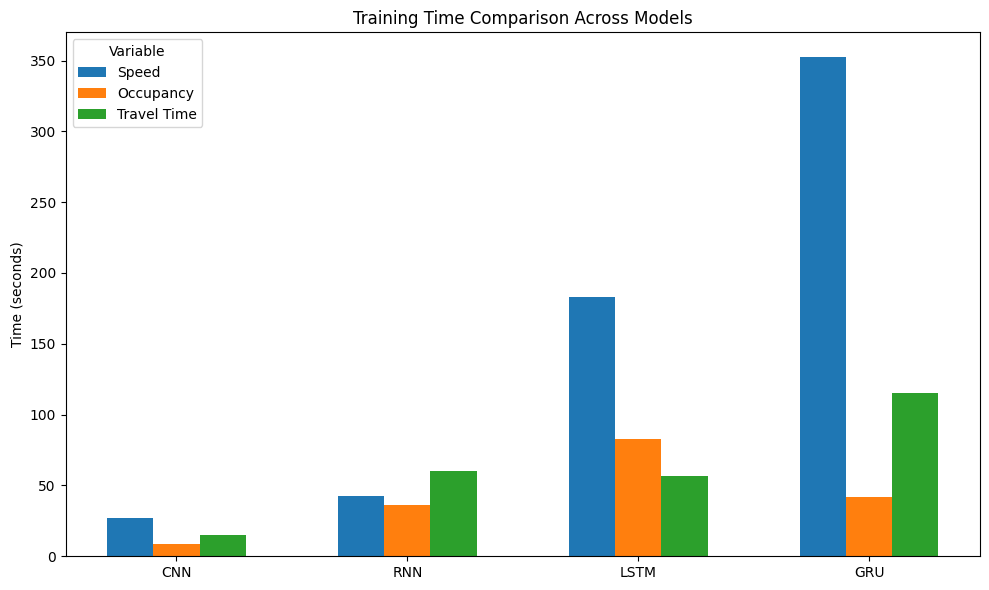

In [156]:
# Training Time
models = ['CNN', 'RNN', 'LSTM', 'GRU']
metrics = ['Speed', 'Occupancy', 'Travel Time']

times = np.array([
    [cnn_time_speed, cnn_time_occupancy, cnn_time_ttime],  # Performance for CNN
    [rnn_time_speed, rnn_time_occupancy, rnn_time_ttime],  # Performance for RNN
    [lstm_time_speed, lstm_time_occupancy, lstm_time_ttime],   # Performance for LSTM
    [gru_time_speed, gru_time_occupancy, gru_time_ttime] # Performance for GRU
])

# Create plot
x = np.arange(len(models))  # 3 models
bar_width = 0.2   # bar width
offsets = np.arange(len(metrics)) * bar_width

fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(metrics):
    ax.bar(x + offsets[i], times[:, i], width=bar_width, label=metric)
# Display the plot
ax.set_ylabel('Time (seconds)')
ax.set_title('Training Time Comparison Across Models')
ax.set_xticks(x + bar_width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models)
ax.legend(title='Variable')

plt.tight_layout()
plt.show()

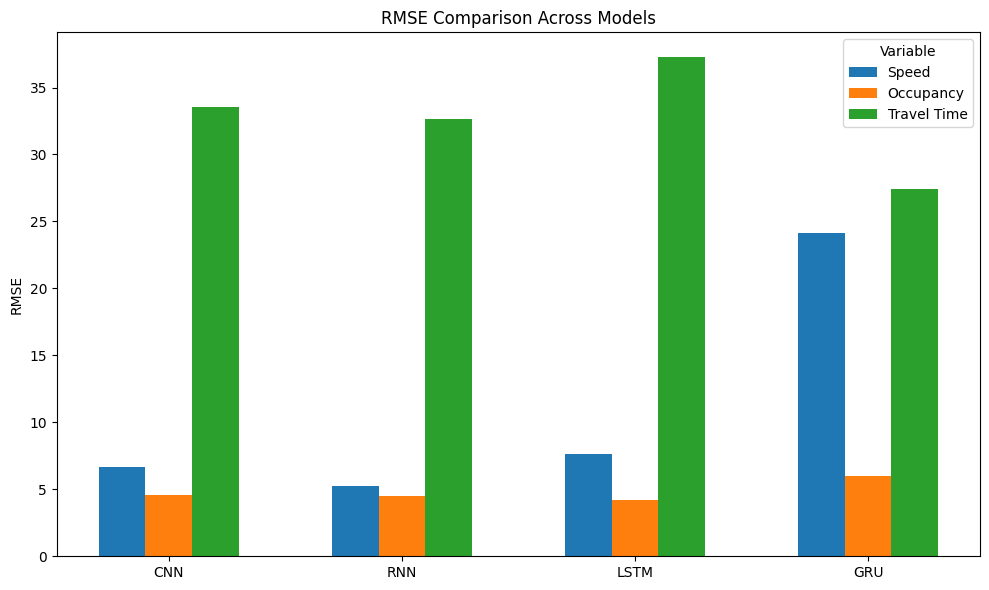

In [157]:
# RMSE
models = ['CNN', 'RNN', 'LSTM', 'GRU']
metrics = ['Speed', 'Occupancy', 'Travel Time']

times = np.array([
    [cnn_rmse_s, cnn_rmse_o, cnn_rmse_t],  # Performance for CNN
    [rnn_rmse_s, rnn_rmse_o, rnn_rmse_t],  # Performance for RNN
    [lstm_rmse_s, lstm_rmse_o, lstm_rmse_t],   # Performance for LSTM
    [gru_rmse_s, gru_rmse_o, gru_rmse_t] # Performance for GRU
])

# Create plot
x = np.arange(len(models))  # 3 models
bar_width = 0.2   # bar width
offsets = np.arange(len(metrics)) * bar_width

fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(metrics):
    ax.bar(x + offsets[i], times[:, i], width=bar_width, label=metric)
# Display the plot
ax.set_ylabel('RMSE')
ax.set_title('RMSE Comparison Across Models')
ax.set_xticks(x + bar_width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models)
ax.legend(title='Variable')

plt.tight_layout()
plt.show()

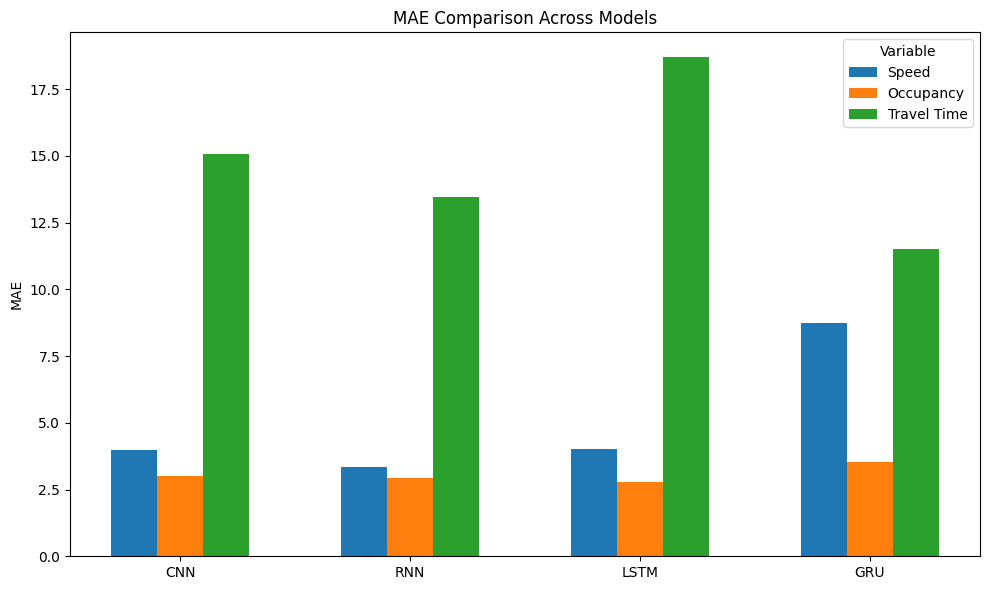

In [158]:
# MAE
models = ['CNN', 'RNN', 'LSTM', 'GRU']
metrics = ['Speed', 'Occupancy', 'Travel Time']

times = np.array([
    [cnn_mae_s, cnn_mae_o, cnn_mae_t],  # Performance for CNN
    [rnn_mae_s, rnn_mae_o, rnn_mae_t],  # Performance for RNN
    [lstm_mae_s, lstm_mae_o, lstm_mae_t],   # Performance for LSTM
    [gru_mae_s, gru_mae_o, gru_mae_t] # Performance for GRU
])

# Create plot
x = np.arange(len(models))  # 4 models
bar_width = 0.2   # bar width
offsets = np.arange(len(metrics)) * bar_width

fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(metrics):
    ax.bar(x + offsets[i], times[:, i], width=bar_width, label=metric)
# Display the plot
ax.set_ylabel('MAE')
ax.set_title('MAE Comparison Across Models')
ax.set_xticks(x + bar_width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models)
ax.legend(title='Variable')

plt.tight_layout()
plt.show()

### Hyperparameter Tuning

- testing RNN with hyperparameter tuning

In [ ]:
# !pip install scikeras
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasRegressor

In [ ]:
def create_model_RNN(units1=30, units2=10, activation='relu', optimizer='adam', dropout1=0.2, dropout2=0.4):
    model = Sequential([
        SimpleRNN(units1, activation=activation, return_sequences=True, input_shape=(Xs_train.shape[1], 1)),
        Dropout(dropout1),
        SimpleRNN(units2, activation=activation),
        Dropout(dropout2),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def grid_search_no_cv(model_type, param_grid, trainX, trainY):
    regressor = KerasRegressor(model=model_type, verbose=0)

    grid_search = GridSearchCV(
        estimator=regressor,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',  # Evaluation metric
        verbose=2  # Monitor grid search progress
    )

    # Perform grid search
    grid_search.fit(trainX, trainY)
    return grid_search.best_estimator_.model_, grid_search.best_params_

# Parameter grid for tuning both layers
param_grid = {
    'model__units1': [20, 25, 30],       # Number of units in the first RNN layer
    'model__units2': [5, 10, 15],       # Number of units in the second RNN layer
    'model__activation': ['relu'],      # Activation functions
    'model__dropout1': [0.2],           # Dropout rate for the first layer
    'model__dropout2': [0.4],           # Dropout rate for the second layer
    'batch_size': [8, 12, 16],          # Batch sizes
    'epochs': [15, 20, 25]              # Number of epochs
}

best_model, best_params = grid_search_no_cv(create_model_RNN, param_grid, Xs_train, ys_train)

# # Display the best parameters
# print("Best Hyperparameters:")
# print(best_params)

In [ ]:
# Best Parameters
gs_pred = best_model.predict(Xs_test)
gs_pred_rescale = scaler_sy.inverse_transform(gs_pred)
print("Best Hyperparameters:", best_params)

Best Hyperparameters:
{'batch_size': 12, 'epochs': 25, 'modelactivation': 'relu', 'modeldropout1': 0.2, 'modeldropout2': 0.4, 'modelunits1': 30, 'model__units2': 15}

In [ ]:
# Calculate RMSE and MAE
gs_rmse_s = np.sqrt(mean_squared_error(ys_test, gs_pred_rescale))
gs_mae_s = mean_absolute_error(ys_test, gs_pred_rescale)

print(f'RNN with Best Params: \'Speed\' RMSE: {gs_rmse_s}')
print(f'RNN with Best Params: \'Speed\' MAE: {gs_mae_s}')

# Plot for Stacked Model
plt.plot(ys_test, label='Actual')
plt.plot(gs_pred_rescale, label='Predicted')
plt.xlabel('Timesteps')
plt.ylabel('km/h')
plt.legend()
plt.title('Predictions with Best Parameters')
plt.tight_layout()
plt.show()

## 4. Forecasting
- Using chosen model, forecast for the next N hours (12*N timesteps)

In [112]:
# Forecast using sliding window approach
def forecast_n_steps(model, input_sequence, n_steps, scaler):

    current_sequence = input_sequence.copy()
    forecast = []

    for _ in range(n_steps):
        # Predict next value
        next_prediction = model.predict(current_sequence, verbose=0)
        forecast.append(next_prediction[0, 0])

        # Update sequence: remove the first value and add the new prediction
        current_sequence = np.append(current_sequence[:, 1:, :], [next_prediction], axis=1)

    # Rescale
    forecast_rescale = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast_rescale.flatten()


Our data ends on 2015-09-17 17:05:00

Forecast N Hours after this

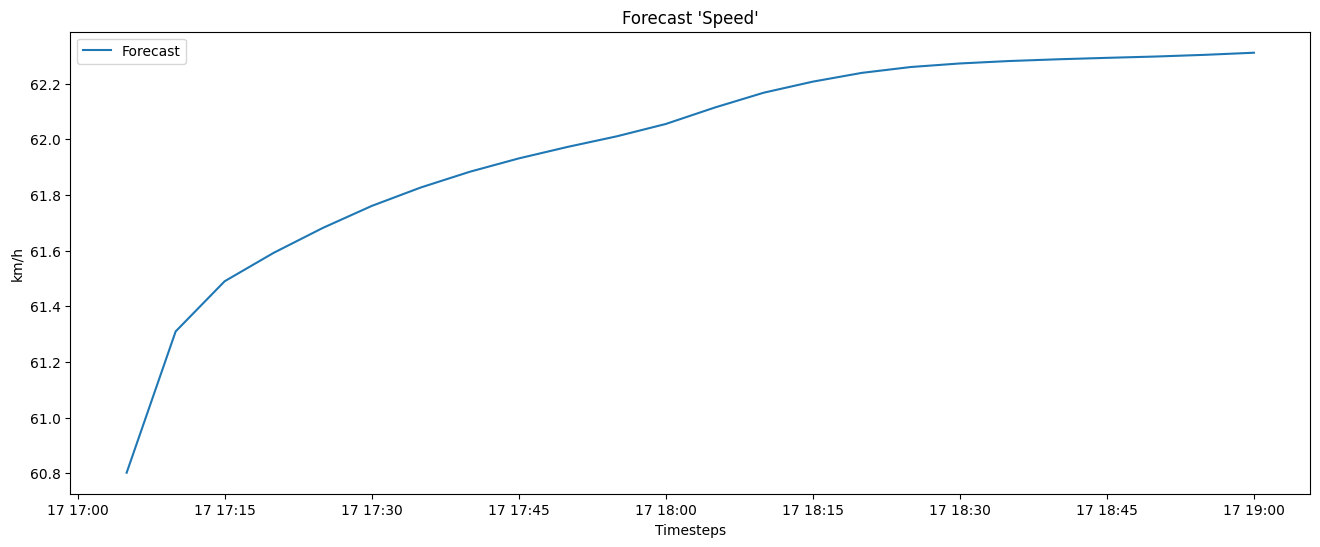

In [169]:
# Speed

N_STEPS = 24

# Use the last sequence from test data as initial input
last_sequence = Xs_test[-1].reshape(1, Xs_test.shape[1], 1)
# Forecast the next N timesteps
forecast_s = forecast_n_steps(model_LSTM_s, last_sequence, n_steps=N_STEPS, scaler=scaler_sy)

# New Time range
future_timesteps = pd.date_range(start='2015-09-17 17:05:00', periods=N_STEPS, freq='5min')

# Plot the forecast of 'Speed'
plt.figure(figsize=(16, 6))
# plt.plot(data['Speed'], label='Original')  # alongside original data
plt.plot(future_timesteps, forecast_s, label='Forecast')
plt.title('Forecast \'Speed\'')
plt.xlabel('Timesteps')
plt.ylabel('km/h')
plt.legend()
plt.show()

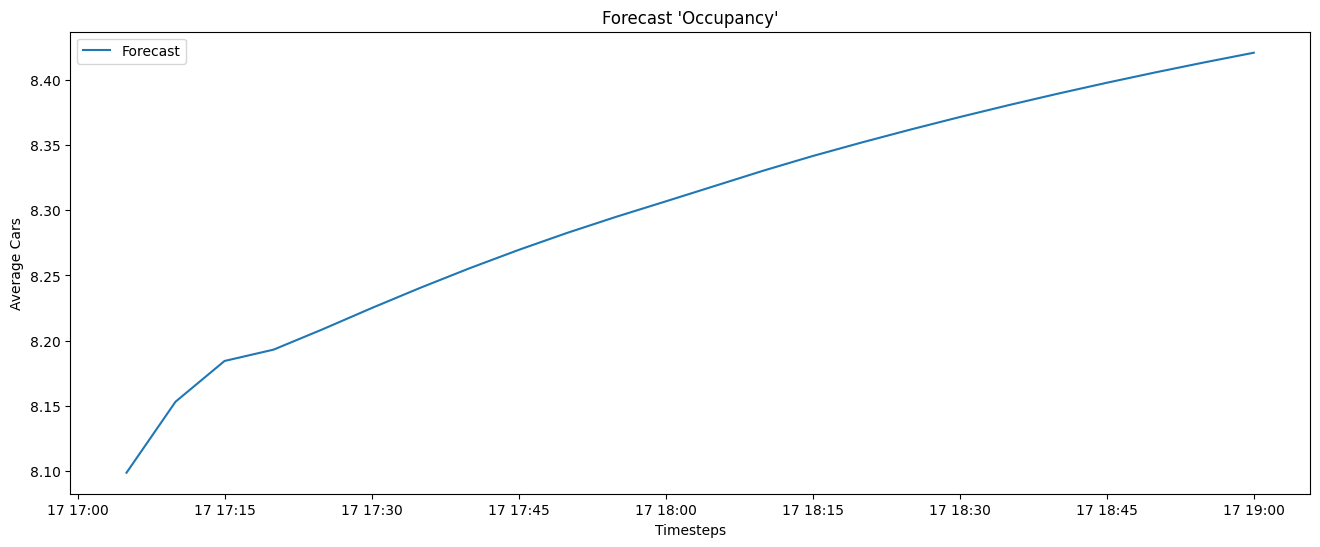

In [170]:
# Occupancy

# Use the last sequence from test data as initial input
last_sequence = Xo_test[-1].reshape(1, Xo_test.shape[1], 1)
# Forecast the next N timesteps
forecast_o = forecast_n_steps(model_LSTM_o, last_sequence, n_steps=N_STEPS, scaler=scaler_oy)

# New Time range
future_timesteps = pd.date_range(start='2015-09-17 17:05:00', periods=N_STEPS, freq='5min')

# Plot the forecast of 'Occupancy'
plt.figure(figsize=(16, 6))
# plt.plot(data['Occupancy'], label='Original')  # alongside original data
plt.plot(future_timesteps, forecast_o, label='Forecast')
plt.title('Forecast \'Occupancy\'')
plt.xlabel('Timesteps')
plt.ylabel('Average Cars')
plt.legend()
plt.show()

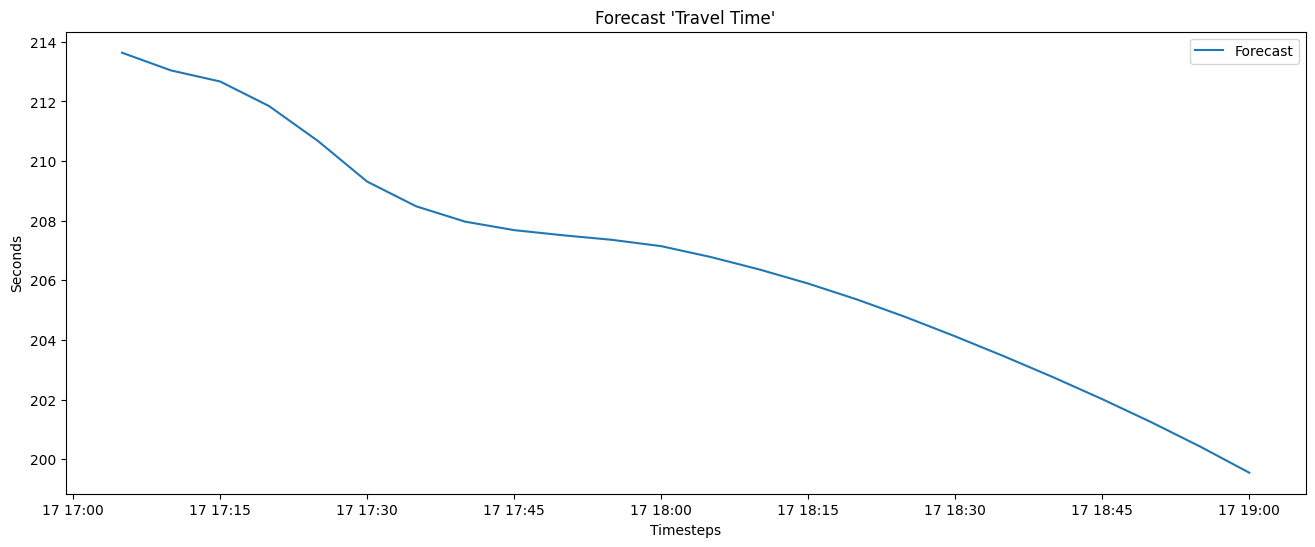

In [171]:
# Travel Time

# Use the last sequence from test data as initial input
last_sequence = Xt_test[-1].reshape(1, Xt_test.shape[1], 1)
# Forecast the next N timesteps
forecast_t = forecast_n_steps(model_LSTM_t, last_sequence, n_steps=N_STEPS, scaler=scaler_ty)

# New Time range
future_timesteps = pd.date_range(start='2015-09-17 17:05:00', periods=N_STEPS, freq='5min')

# Plot the forecast of 'Travel Time'
plt.figure(figsize=(16, 6))
# plt.plot(data['Travel Time'], label='Original')  # alongside original data
plt.plot(future_timesteps, forecast_t, label='Forecast')
plt.title('Forecast \'Travel Time\'')
plt.xlabel('Timesteps')
plt.ylabel('Seconds')
plt.legend()
plt.show()